In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path_сifar = os.path.join(cwd, '..', 'tools', 'cifar10_utils')
api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')
models_cifar_scratch_path = os.path.join(cwd, '..', 'models_cifar10')
#models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'wasserstein')
sys.path.append(api_path_сifar)
sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)

In [3]:
import numpy as np
import time
import random
import glob
import importlib
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from distributions import IndependentNormal
import torchvision.transforms as transforms

from functools import partial

from dataloader import get_loader
from trainer import Trainer
from discriminator import Discriminator
from generator import Generator
from cifar10_utils import (plot_images, 
                           save_images_for_fid,
                           save_images_for_fid_fix_latent,
                           z_transform,
                           delete_local_files,
                           delete_saved_files_for_cifar10_statistics,
                           calculate_cifar10_statistics,
                           plot_scores_cifar10_dynamics)

from params_cifar10 import args
from general_utils import to_var, DotDict, to_np

from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from metrics import inception_score
from dataloader import GenDataset, LatentFixDataset

# DCGAN from scratch

In [6]:
args.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = args.device

G = Generator(args).to(args.device)
D = Discriminator(args).to(args.device)

In [7]:
models_regexp = os.path.join(models_cifar_scratch_path, "*.pth")
models_name = [f for f in glob.glob(models_regexp)][0]

In [8]:
ckpt = torch.load(models_name, map_location = device)

In [ ]:
G.load_state_dict(ckpt['G'])
D.load_state_dict(ckpt['D'])

In [12]:
G.eval()
D.eval()

Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
    (2): SpectralNorm(
      (module): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
    (2): SpectralNorm(
      (module): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
    (2): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): LeakyReLU(negative_slope=0.1)

In [13]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
nsamples = 64
fixed_z = torch.randn(nsamples, G.z_dim)

In [14]:
fixed_z_var = to_var(fixed_z, device = args.device)
samples = G(fixed_z_var)
samples_normalized = ((samples + 1) / 2).clamp(0, 1)

In [15]:
images_torch = samples_normalized.data

In [16]:
images_torch.shape

torch.Size([64, 3, 32, 32])

In [17]:
def plot_images(images_torch):
    batch_size_sample = images_torch.shape[0]
    numpy_images = images_torch.detach().cpu().numpy().transpose(0, 2, 3, 1)
    numpy_images = (numpy_images - numpy_images.min())/(numpy_images.max() - numpy_images.min())
    nrow = int(batch_size_sample**0.5)
    fig = plt.figure(figsize=(20, 20))
    axes = fig.subplots(nrow, nrow)
    for k in range(batch_size_sample):
        i = k // nrow
        j = k % nrow
        #axes[i][j].imshow(np.clip(numpy_images[k], 0, 1))
        axes[i][j].imshow(numpy_images[k])
        axes[i][j].axis('off')
    plt.show()

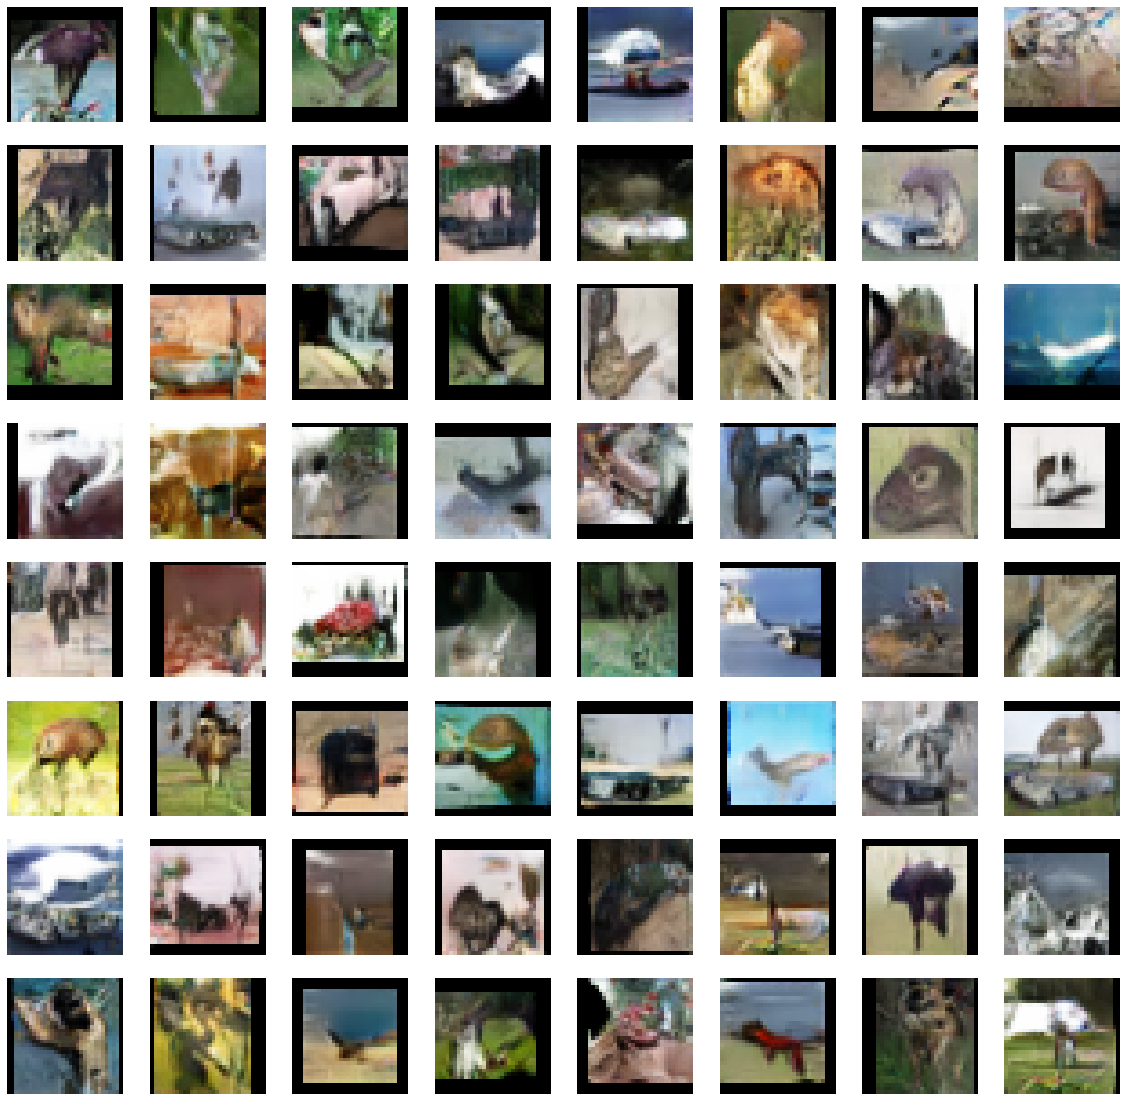

In [18]:
plot_images(images_torch)

In [39]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
nsamples = 64
fixed_z = torch.randn(nsamples, G.z_dim)
fixed_z_var = to_var(fixed_z, device = args.device)
fake_imgs = G(fixed_z_var).detach()

D_outputs = D(fake_imgs)

In [40]:
print(D_outputs.cpu().data)

tensor([ 0.4882, -0.0089, -0.4454, -0.4099, -1.0083, -0.2816, -0.6268, -0.6639,
        -0.8809, -0.3667, -1.0376, -1.2791, -1.0204, -0.2664, -0.5179, -0.5680,
        -0.7019, -0.8253, -0.5849, -0.5829, -0.3266, -0.2924, -0.7480,  0.1548,
        -1.1504, -0.7655, -0.8689, -0.6749, -0.4382, -0.4512, -0.4666, -1.0219,
        -0.8999,  0.3879,  0.3935, -0.9945, -0.4973, -0.2164, -0.7172,  0.1660,
        -0.1303, -0.1041, -0.8570, -0.6268, -0.8746, -0.4242, -1.0792, -0.8190,
        -1.1584, -0.3265, -0.8152, -0.3668, -0.7580, -0.0855,  0.0222, -0.5584,
        -0.5298, -0.7238, -0.3428, -0.5520, -0.2844, -0.4112, -0.3965, -0.1336])


In [28]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
num_samples = 50000
dataset = GenDataset(G, num_samples)

In [29]:
start = time.time()
score_mean, score_std = inception_score(dataset, device, args.batch_size, True)
end = time.time() - start
print(f"time for inception calculation = {end}")

Start to make predictions
Start to compute KL divergence
time for inception calculation = 380.4678430557251


In [30]:
print(f"inception score = {score_mean}")

inception score = 4.324181273940167


In [31]:
score_std

0.05538793339919849

# ULA

In [ ]:
z_dim = G.z_dim
device = args.device
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True
target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [23]:
batch_size = 1000
n = 50000
n_steps = 100
grad_step = 0.01
eps_scale = (2*grad_step)**0.5
z_last_np, zs = langevin_sampling(target_gan, proposal, n_steps, grad_step, eps_scale, n, batch_size)

100%|██████████| 50/50 [31:17<00:00, 37.55s/it]


In [24]:
nsamples = len(z_last_np)
latent_arr = torch.FloatTensor(z_last_np)
latent_dataset = LatentFixDataset(latent_arr, G, device, nsamples)

In [25]:
score_mean_langevin, score_std_langevin = inception_score(latent_dataset, device, args.batch_size, True)

Start to make predictions
Start to compute KL divergence


In [26]:
print(f"inception score for Langevin = {score_mean_langevin}")

inception score for Langevin = 4.455136821353747


In [27]:
score_std_langevin

0.060840390273751495

In [32]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
nsamples = 64
fixed_z = torch.randn(nsamples, G.z_dim)
fixed_z_var = to_var(fixed_z, device = args.device)
n_steps = 100
grad_step = 0.01
eps_scale = (2*grad_step)**0.5

z_sp = langevin_dynamics(fixed_z_var, target_gan, proposal, n_steps, grad_step, eps_scale)

In [33]:
last = z_sp[-1].data.cpu().numpy()

In [34]:
last_tensor = torch.FloatTensor(last)
last_var = to_var(last_tensor, device = args.device)
samples_last = G(last_var)
samples_normalized_last = ((samples_last + 1) / 2).clamp(0, 1)
images_torch_langevin = samples_normalized_last.data

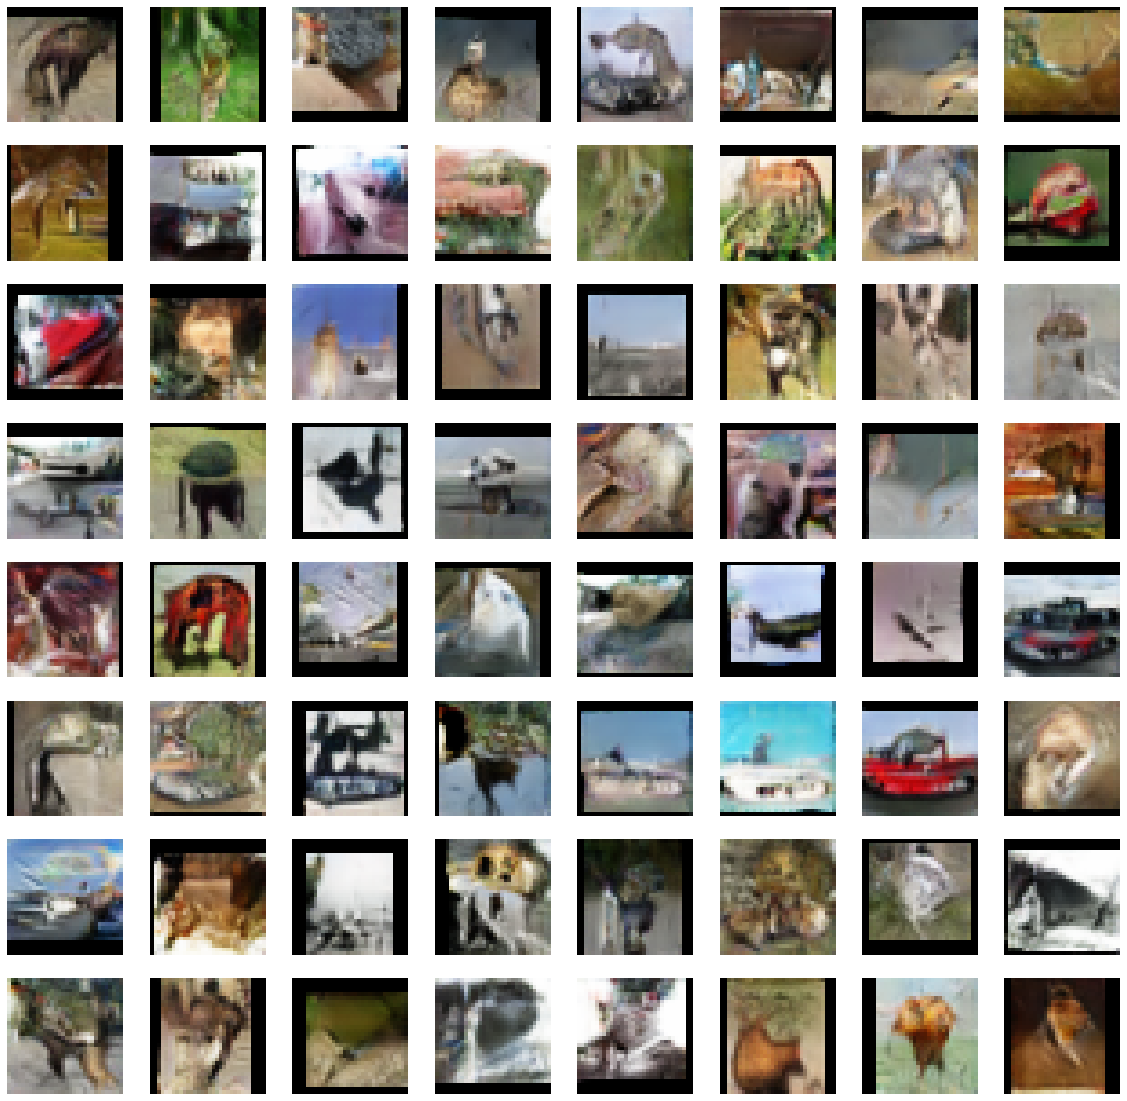

In [35]:
plot_images(images_torch_langevin)

In [36]:
D_outputs_langevin = D(images_torch_langevin)

In [41]:
print(D_outputs_langevin.cpu().data)

tensor([-0.1690,  0.6560, -0.1439, -0.1246, -0.6413, -0.4309,  0.2597, -0.2173,
         0.3261,  0.0961, -0.1336, -0.3123,  0.1727,  0.3406, -0.5417,  0.2734,
         0.6052, -0.7443,  0.3562,  0.5413, -0.0608, -0.3527,  0.1708, -0.2577,
        -0.6245, -0.1478,  0.9162, -0.3999, -0.0508, -0.1695, -0.0988, -0.1366,
        -0.5102,  0.6957,  0.0136, -0.1176, -0.3694, -0.3381,  0.3602, -0.3670,
        -0.3144, -0.3400, -0.0491, -0.4607,  0.0170,  0.3036, -0.0179, -0.4077,
         0.1317,  0.0519,  0.9208, -0.2873, -0.0903, -0.1310, -0.0449, -0.5860,
        -0.7238, -0.0621,  0.7971, -0.6163, -0.4775,  0.9715,  0.3001,  0.7699])


In [43]:
D_outputs.cpu().data

tensor([ 0.4882, -0.0089, -0.4454, -0.4099, -1.0083, -0.2816, -0.6268, -0.6639,
        -0.8809, -0.3667, -1.0376, -1.2791, -1.0204, -0.2664, -0.5179, -0.5680,
        -0.7019, -0.8253, -0.5849, -0.5829, -0.3266, -0.2924, -0.7480,  0.1548,
        -1.1504, -0.7655, -0.8689, -0.6749, -0.4382, -0.4512, -0.4666, -1.0219,
        -0.8999,  0.3879,  0.3935, -0.9945, -0.4973, -0.2164, -0.7172,  0.1660,
        -0.1303, -0.1041, -0.8570, -0.6268, -0.8746, -0.4242, -1.0792, -0.8190,
        -1.1584, -0.3265, -0.8152, -0.3668, -0.7580, -0.0855,  0.0222, -0.5584,
        -0.5298, -0.7238, -0.3428, -0.5520, -0.2844, -0.4112, -0.3965, -0.1336])

In [42]:
(D_outputs.cpu().data < D_outputs_langevin.cpu().data).sum()

tensor(48)

# Pretrained DCGAN

In [4]:
from fid_score import calculate_fid_given_paths
from kid_score import calculate_kid_given_paths
from params_cifar10 import args

In [4]:
num_gpu = 1 if torch.cuda.is_available() else 0

# load the models
from dcgan import (Discriminator_cifar10, 
                   Discriminator_cifar10_logits,
                   Generator_cifar10)

D = Discriminator_cifar10(ngpu=1).eval()
G = Generator_cifar10(ngpu=1).eval()
D_logits = Discriminator_cifar10_logits(D, ngpu=1).eval()

# load weights
D.load_state_dict(torch.load(os.path.join(models_cifar_scratch_path, 'netD_epoch_199.pth')))
G.load_state_dict(torch.load(os.path.join(models_cifar_scratch_path, 'netG_epoch_199.pth')))

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    D = D.to(device)
    G = G.to(device)
    D_logits = D_logits.to(device)
    
G.z_dim = 100
G.device = device
z_dim = 100

In [5]:
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True

def z_transform(z):
    return z.unsqueeze(-1).unsqueeze(-1)

target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D_logits, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob,
                     z_transform = z_transform)

In [67]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n, n_steps, grad_step, eps_scale)

100%|██████████| 50/50 [3:48:09<00:00, 273.79s/it]  


In [73]:
zs.shape

(50, 1001, 1000, 100)

In [74]:
zs.dtype

dtype('float32')

In [72]:
method_name = 'ula'
path_to_save_cifar10_np = os.path.join(cwd, '..', 'samples', 'cifar10', 'numpy_files')
history_file_name_ula = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}.npy'
ula_file_name = os.path.join(path_to_save_cifar10_np, history_file_name_ula)
np.save(ula_file_name, zs)

In [6]:
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
method_name = 'ula'
batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
history_file_name_ula = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}.npy'
path_to_read_ula_latent_vectors = os.path.join(path_to_np_files, history_file_name_ula)
zs = np.load(path_to_read_ula_latent_vectors)

In [7]:
every_step = 50
z_agg = aggregate_sampling_output(zs)
z_agg_step = z_agg[::every_step, :, :]
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
history_file_name_ula_small = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_small.npy'
path_to_save_ula_latent_vectors_small = os.path.join(path_to_np_files, history_file_name_ula_small)
np.save(path_to_save_ula_latent_vectors_small, z_agg_step)


In [6]:
method_name = 'ula'
batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
history_file_name_ula_small = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_small.npy'
path_to_read_ula_latent_vectors_small = os.path.join(path_to_np_files, history_file_name_ula_small)
z_agg_step = np.load(path_to_read_ula_latent_vectors_small)

In [7]:
method_name = 'ula'
random_seed = 42
every_step = 50
path_to_save_cifar10 = os.path.join(cwd, '..', 'samples', 'cifar10', 'downloaded_dataset')
path_to_save_cifar10_np = os.path.join(cwd, '..', 'samples', 'cifar10', 'numpy_files')
(inception_scores_mean,
 inception_scores_std,
 fid_scores_mean_train,
 fid_scores_mean_test,
 fid_scores_std_train,
 fid_scores_std_test) = calculate_cifar10_statistics(z_agg_step = z_agg_step, 
                                                     G = G,
                                                     device = device, 
                                                     batch_size = args.batch_size,
                                                     path_to_save_cifar10 = path_to_save_cifar10,
                                                     path_to_save_cifar10_np = path_to_save_cifar10_np,
                                                     method_name = method_name,
                                                     random_seed = random_seed,
                                                     every_step = every_step)

Files already downloaded and verified
Files already downloaded and verified
------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 5.45884757258539, std inception score = 0.07988136341616872
time for inception calculation = 396.722s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.05it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_0.npy


FID: 100%|██████████| 10/10 [00:40<00:00,  4.04s/it, mean=39.6]

FID score for test CIFAR10 with ula: mean 39.62882295543382, score 0.4578858817004737
time for FID calculation on test = 87.964s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:52,  8.88it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [01:27<00:00,  8.78s/it, mean=35.7]


FID score for train CIFAR10 with ula: mean 35.716967444687825, score 0.22371321329750932
time for FID calculation on train = 328.457s
------------------------------------
step = 50
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 5.6453325120842, std inception score = 0.06556845292357019
time for inception calculation = 419.883s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:26,  7.51it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_50.npy


FID: 100%|██████████| 10/10 [01:11<00:00,  7.14s/it, mean=45.2]

FID score for test CIFAR10 with ula: mean 45.215968221926474, score 0.7777033557657044
time for FID calculation on test = 136.647s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<02:30,  6.64it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_50.npy


FID: 100%|██████████| 10/10 [01:49<00:00, 10.98s/it, mean=41.2]


FID score for train CIFAR10 with ula: mean 41.23658666158131, score 0.2741671124026705
time for FID calculation on train = 443.538s
------------------------------------
step = 100
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 5.933026773965763, std inception score = 0.07513579429437027
time for inception calculation = 395.027s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.10it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_100.npy


FID: 100%|██████████| 10/10 [00:38<00:00,  3.83s/it, mean=39.5]

FID score for test CIFAR10 with ula: mean 39.45932566694291, score 0.6813296007537125
time for FID calculation on test = 85.074s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:58,  8.46it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_100.npy


FID: 100%|██████████| 10/10 [01:47<00:00, 10.79s/it, mean=34.9]


FID score for train CIFAR10 with ula: mean 34.94264839153134, score 0.2514279902147131
time for FID calculation on train = 348.329s
------------------------------------
step = 150
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.110757245292211, std inception score = 0.09356252621319906
time for inception calculation = 396.933s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.08it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_150.npy


FID: 100%|██████████| 10/10 [00:39<00:00,  3.98s/it, mean=34.7]

FID score for test CIFAR10 with ula: mean 34.710352110927865, score 0.6580956786850805
time for FID calculation on test = 87.185s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.63it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_150.npy


FID: 100%|██████████| 10/10 [02:04<00:00, 12.47s/it, mean=30] 


FID score for train CIFAR10 with ula: mean 29.99145377162962, score 0.1517853805306775
time for FID calculation on train = 364.445s
------------------------------------
step = 200
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.263323354681277, std inception score = 0.09139792811252409
time for inception calculation = 396.972s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:22,  9.01it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_200.npy


FID: 100%|██████████| 10/10 [00:49<00:00,  4.95s/it, mean=31.9]

FID score for test CIFAR10 with ula: mean 31.902881456846295, score 0.3899918564140042
time for FID calculation on test = 98.706s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<02:31,  6.58it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_200.npy


FID: 100%|██████████| 10/10 [03:09<00:00, 18.92s/it, mean=26.8]


FID score for train CIFAR10 with ula: mean 26.83238766402878, score 0.17803870641673272
time for FID calculation on train = 505.068s
------------------------------------
step = 250
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.331292260899952, std inception score = 0.03638079208994599
time for inception calculation = 470.221s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:28,  6.88it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_250.npy


FID: 100%|██████████| 10/10 [01:15<00:00,  7.59s/it, mean=30.4]

FID score for test CIFAR10 with ula: mean 30.431144018796978, score 0.4471076476930395
time for FID calculation on test = 139.791s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<02:33,  6.52it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_250.npy


FID: 100%|██████████| 10/10 [03:04<00:00, 18.42s/it, mean=25.4]


FID score for train CIFAR10 with ula: mean 25.433018903943218, score 0.2094811558103951
time for FID calculation on train = 499.653s
------------------------------------
step = 300
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.347283451964026, std inception score = 0.06738577434075567
time for inception calculation = 465.58s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:38,  5.12it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_300.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.90s/it, mean=30] 

FID score for test CIFAR10 with ula: mean 29.97871582978401, score 0.31547667938036766
time for FID calculation on test = 145.556s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_300.npy


FID: 100%|██████████| 10/10 [03:00<00:00, 18.09s/it, mean=24.9]


FID score for train CIFAR10 with ula: mean 24.85777145386432, score 0.22552444880044897
time for FID calculation on train = 503.18s
------------------------------------
step = 350
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.449974793914532, std inception score = 0.06851357698538231
time for inception calculation = 454.276s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.13it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_350.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.57s/it, mean=30] 

FID score for test CIFAR10 with ula: mean 29.960495453618826, score 0.463105238990995
time for FID calculation on test = 82.204s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.64it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_350.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.30s/it, mean=24.9]


FID score for train CIFAR10 with ula: mean 24.914468345851844, score 0.16742129077942056
time for FID calculation on train = 320.677s
------------------------------------
step = 400
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.469833597087719, std inception score = 0.08193226086418644
time for inception calculation = 391.855s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.11it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_400.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it, mean=31.2]

FID score for test CIFAR10 with ula: mean 31.224292944213698, score 0.4088956387205892
time for FID calculation on test = 82.591s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.74it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_400.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.31s/it, mean=25.5]


FID score for train CIFAR10 with ula: mean 25.510140686451287, score 0.19986428848659019
time for FID calculation on train = 320.716s
------------------------------------
step = 450
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.466275945284837, std inception score = 0.12731708911100048
time for inception calculation = 397.763s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.15it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_450.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.56s/it, mean=31.7]

FID score for test CIFAR10 with ula: mean 31.662073873916047, score 0.454382184530831
time for FID calculation on test = 82.046s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.58it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_450.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.31s/it, mean=26.4]


FID score for train CIFAR10 with ula: mean 26.431382976445025, score 0.19882782219493308
time for FID calculation on train = 321.12s
------------------------------------
step = 500
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.495176401048489, std inception score = 0.08449640978148754
time for inception calculation = 394.272s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.16it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_500.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.60s/it, mean=33.1]

FID score for test CIFAR10 with ula: mean 33.061712449341066, score 0.4102367233571234
time for FID calculation on test = 82.25s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.64it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_500.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.16s/it, mean=27.7]


FID score for train CIFAR10 with ula: mean 27.659984652359135, score 0.19608401190134273
time for FID calculation on train = 319.173s
------------------------------------
step = 550
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.498044270948713, std inception score = 0.06955035793063723
time for inception calculation = 393.993s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.19it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_550.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it, mean=34.2]

FID score for test CIFAR10 with ula: mean 34.200920171451195, score 0.39106590559689425
time for FID calculation on test = 82.328s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.75it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_550.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.22s/it, mean=28.9]


FID score for train CIFAR10 with ula: mean 28.877469206699942, score 0.1608907827615855
time for FID calculation on train = 319.823s
------------------------------------
step = 600
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.5006213841109455, std inception score = 0.051627488248539986
time for inception calculation = 391.547s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.19it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_600.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it, mean=35.7]

FID score for test CIFAR10 with ula: mean 35.711815675012225, score 0.4131252210113968
time for FID calculation on test = 82.78s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.68it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_600.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.33s/it, mean=30.4]


FID score for train CIFAR10 with ula: mean 30.419643522761778, score 0.19806479892047169
time for FID calculation on train = 321.171s
------------------------------------
step = 650
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.486893000138588, std inception score = 0.0504825674565356
time for inception calculation = 395.557s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.33it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_650.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it, mean=37.3]

FID score for test CIFAR10 with ula: mean 37.288465381369875, score 0.4401725154061759
time for FID calculation on test = 82.545s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.69it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_650.npy


FID: 100%|██████████| 10/10 [03:15<00:00, 19.51s/it, mean=31.9]


FID score for train CIFAR10 with ula: mean 31.89948226894047, score 0.1971615980714933
time for FID calculation on train = 432.706s
------------------------------------
step = 700
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.457678136965621, std inception score = 0.08984081255416568
time for inception calculation = 540.746s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.10it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_700.npy


FID: 100%|██████████| 10/10 [00:39<00:00,  3.92s/it, mean=38.8]

FID score for test CIFAR10 with ula: mean 38.800588645838666, score 0.4613253062061852
time for FID calculation on test = 86.437s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.72it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_700.npy


FID: 100%|██████████| 10/10 [01:45<00:00, 10.52s/it, mean=33.4]


FID score for train CIFAR10 with ula: mean 33.36489926822574, score 0.17161143008902194
time for FID calculation on train = 349.613s
------------------------------------
step = 750
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.485135361464795, std inception score = 0.06764605272229128
time for inception calculation = 414.342s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:22,  9.00it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_750.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.71s/it, mean=39.9]

FID score for test CIFAR10 with ula: mean 39.917532161935966, score 0.4751194388527183
time for FID calculation on test = 83.802s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.67it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_750.npy


FID: 100%|██████████| 10/10 [01:29<00:00,  8.92s/it, mean=34.7]


FID score for train CIFAR10 with ula: mean 34.72285885383768, score 0.21229463624082145
time for FID calculation on train = 327.934s
------------------------------------
step = 800
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.396643694770927, std inception score = 0.06941958144895703
time for inception calculation = 394.107s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:22,  9.03it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_800.npy


FID: 100%|██████████| 10/10 [00:39<00:00,  3.95s/it, mean=41.2]

FID score for test CIFAR10 with ula: mean 41.19187441077898, score 0.47649868780021254
time for FID calculation on test = 87.033s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:57,  8.52it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_800.npy


FID: 100%|██████████| 10/10 [01:27<00:00,  8.73s/it, mean=36.2]


FID score for train CIFAR10 with ula: mean 36.21797334953617, score 0.24326892618416246
time for FID calculation on train = 326.537s
------------------------------------
step = 850
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.416372012497431, std inception score = 0.08379179563122775
time for inception calculation = 393.14s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.21it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_850.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.65s/it, mean=42.8]

FID score for test CIFAR10 with ula: mean 42.76864996254157, score 0.46514132912533707
time for FID calculation on test = 82.662s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.69it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_850.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.23s/it, mean=37.6]


FID score for train CIFAR10 with ula: mean 37.62613860022287, score 0.23913440971734717
time for FID calculation on train = 320.56s
------------------------------------
step = 900
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.365678908633849, std inception score = 0.07713408695371761
time for inception calculation = 394.466s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.17it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_900.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it, mean=44] 

FID score for test CIFAR10 with ula: mean 43.993551080443495, score 0.4869870263364509
time for FID calculation on test = 82.467s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.67it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_900.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.48s/it, mean=38.9]


FID score for train CIFAR10 with ula: mean 38.9148296011286, score 0.22333403209308855
time for FID calculation on train = 322.281s
------------------------------------
step = 950
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.350099910246934, std inception score = 0.08823519418046012
time for inception calculation = 393.025s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.21it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_950.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.71s/it, mean=45.5]

FID score for test CIFAR10 with ula: mean 45.457512294041834, score 0.5520778889099536
time for FID calculation on test = 83.342s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:50,  9.01it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_950.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.41s/it, mean=40.3]


FID score for train CIFAR10 with ula: mean 40.345189899340525, score 0.2150075371885218
time for FID calculation on train = 320.528s
------------------------------------
step = 1000
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula mean inception score = 6.309950725247816, std inception score = 0.06783956224302244
time for inception calculation = 393.587s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.09it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_test_step_1000.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it, mean=46.9]

FID score for test CIFAR10 with ula: mean 46.88468199990074, score 0.5916503954029333
time for FID calculation on test = 82.982s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.60it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/ula_pretrained_fake_train_step_1000.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.36s/it, mean=41.9]

FID score for train CIFAR10 with ula: mean 41.87512163122073, score 0.2449252218579044
time for FID calculation on train = 321.502s


In [8]:
inception_scores_mean = np.array(inception_scores_mean)
inception_scores_std = np.array(inception_scores_std)
fid_scores_mean_train = np.array(fid_scores_mean_train)
fid_scores_mean_test = np.array(fid_scores_mean_test)
fid_scores_std_train = np.array(fid_scores_std_train)
fid_scores_std_test = np.array(fid_scores_std_test)

In [9]:
method_name = 'ula'
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
name_inception_mean = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_inception_mean.npy'
path_to_save_inception_mean = os.path.join(path_to_np_files, name_inception_mean)
np.save(path_to_save_inception_mean, inception_scores_mean)
name_inception_std = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_inception_std.npy'
path_to_save_inception_std = os.path.join(path_to_np_files, name_inception_std)
np.save(path_to_save_inception_std, inception_scores_std)
name_fid_mean_train = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_mean_train.npy'
path_to_save_fid_mean_train = os.path.join(path_to_np_files, name_fid_mean_train)
np.save(path_to_save_fid_mean_train, fid_scores_mean_train)
name_fid_mean_test = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_mean_test.npy'
path_to_save_fid_mean_test = os.path.join(path_to_np_files, name_fid_mean_test)
np.save(path_to_save_fid_mean_test, fid_scores_mean_test)
name_fid_std_train = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_std_train.npy'
path_to_save_fid_std_train = os.path.join(path_to_np_files, name_fid_std_train)
np.save(path_to_save_fid_std_train, fid_scores_std_train)
name_fid_std_test = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_std_test.npy'
path_to_save_fid_std_test = os.path.join(path_to_np_files, name_fid_std_test)
np.save(path_to_save_fid_std_test, fid_scores_std_test)

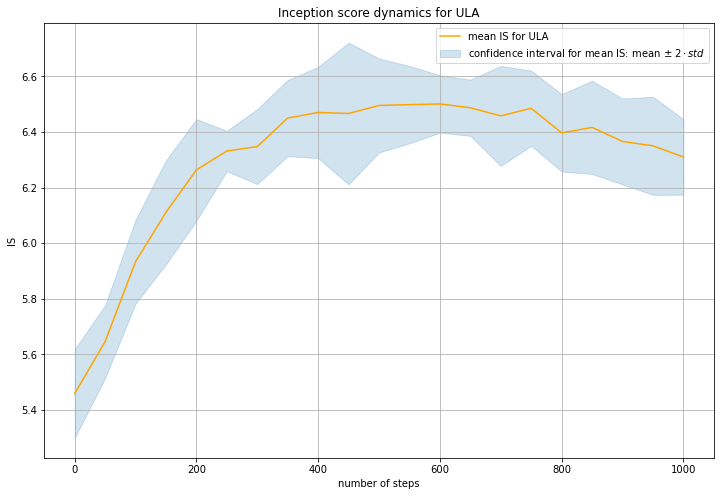

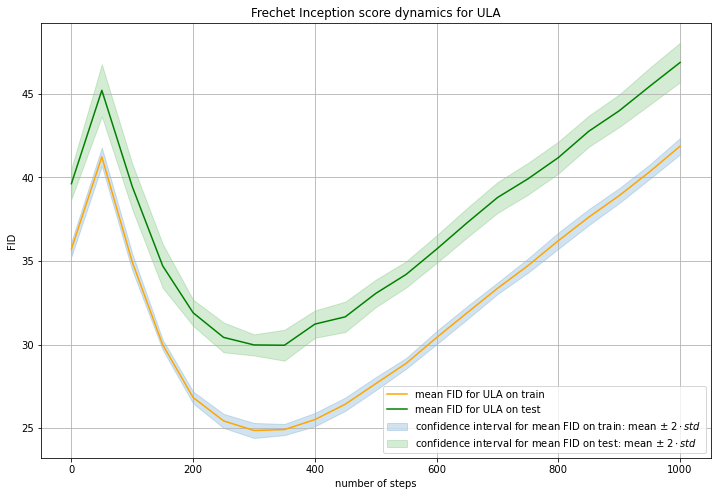

In [27]:
method_name = "ULA"
figsize = (12, 8)
plot_scores_cifar10_dynamics(inception_scores_mean,
                                 inception_scores_std,
                                 fid_scores_mean_train,
                                 fid_scores_mean_test,
                                 fid_scores_std_train,
                                 fid_scores_std_test,
                                 every_step, method_name,
                                 figsize,
                                 path_to_np_files,
                                 grad_step,
                                 eps_scale,
                                 coef = 2.0)

In [28]:
method_name = 'ula'
every_step = 50
delete_saved_files_for_cifar10_statistics(z_agg_step,
                                          path_to_save_cifar10_np,
                                          method_name,
                                          every_step = every_step)

In [8]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 1000
n = 50000
n_steps = 400
grad_step = 0.01
eps_scale = 0.1
acceptance_rule = 'Hastings'
z_last_np_mala, zs_mala = mala_sampling(target_gan, proposal, 
                                        batch_size, n, n_steps, 
                                        grad_step, eps_scale, acceptance_rule)

100%|██████████| 50/50 [3:02:13<00:00, 218.67s/it]  


In [9]:
method_name = 'mala'
path_to_save_cifar10_np = os.path.join(cwd, '..', 'samples', 'cifar10', 'numpy_files')
history_file_name_mala = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}.npy'
mala_file_name = os.path.join(path_to_save_cifar10_np, history_file_name_mala)
np.save(mala_file_name, zs_mala)



In [10]:
every_step = 20
z_agg = aggregate_sampling_output(zs_mala)
z_agg_step = z_agg[::every_step, :, :]
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
history_file_name_mala_small = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_small.npy'
path_to_save_mala_latent_vectors_small = os.path.join(path_to_np_files, history_file_name_mala_small)
np.save(path_to_save_mala_latent_vectors_small, z_agg_step)



In [11]:
method_name = 'mala'
random_seed = 42
every_step = 20
path_to_save_cifar10 = os.path.join(cwd, '..', 'samples', 'cifar10', 'downloaded_dataset')
path_to_save_cifar10_np = os.path.join(cwd, '..', 'samples', 'cifar10', 'numpy_files')
(inception_scores_mean,
 inception_scores_std,
 fid_scores_mean_train,
 fid_scores_mean_test,
 fid_scores_std_train,
 fid_scores_std_test) = calculate_cifar10_statistics(z_agg_step = z_agg_step, 
                                                     G = G,
                                                     device = device, 
                                                     batch_size = args.batch_size,
                                                     path_to_save_cifar10 = path_to_save_cifar10,
                                                     path_to_save_cifar10_np = path_to_save_cifar10_np,
                                                     method_name = method_name,
                                                     random_seed = random_seed,
                                                     every_step = every_step)

Files already downloaded and verified
Files already downloaded and verified
------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.457611267575411, std inception score = 0.07552230929647936
time for inception calculation = 394.583s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.16it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_0.npy


FID: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it, mean=40.8]

FID score for test CIFAR10 with mala: mean 40.78506144819426, score 0.38194016106876444
time for FID calculation on test = 85.023s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:52,  8.84it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.32s/it, mean=35.7]


FID score for train CIFAR10 with mala: mean 35.65191474920126, score 0.1744683531909217
time for FID calculation on train = 319.764s
------------------------------------
step = 20
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.436030979404022, std inception score = 0.05940673729918284
time for inception calculation = 396.543s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.12it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_20.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it, mean=42.1]

FID score for test CIFAR10 with mala: mean 42.10851536549881, score 0.4129106076828471
time for FID calculation on test = 83.537s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.61it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_20.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.38s/it, mean=36.7]


FID score for train CIFAR10 with mala: mean 36.73795148353703, score 0.16204431028059452
time for FID calculation on train = 322.527s
------------------------------------
step = 40
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.4212162353396005, std inception score = 0.05740268001949781
time for inception calculation = 395.017s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:22,  8.94it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_40.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it, mean=42.3]

FID score for test CIFAR10 with mala: mean 42.31084233514191, score 0.43727193781848034
time for FID calculation on test = 83.433s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.62it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_40.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.31s/it, mean=37.2]


FID score for train CIFAR10 with mala: mean 37.21684976273663, score 0.15604758071652416
time for FID calculation on train = 322.031s
------------------------------------
step = 60
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.425382846118349, std inception score = 0.08673579536521504
time for inception calculation = 396.458s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.17it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_60.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.67s/it, mean=42.5]

FID score for test CIFAR10 with mala: mean 42.529044283118104, score 0.42349304321508335
time for FID calculation on test = 83.205s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.74it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_60.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.29s/it, mean=37.1]


FID score for train CIFAR10 with mala: mean 37.14226506893673, score 0.12776605742297825
time for FID calculation on train = 321.265s
------------------------------------
step = 80
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.432855331575441, std inception score = 0.05467481136364543
time for inception calculation = 394.169s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.17it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_80.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it, mean=42.1]

FID score for test CIFAR10 with mala: mean 42.05074527727653, score 0.379999986800461
time for FID calculation on test = 83.071s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.68it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_80.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.31s/it, mean=36.9]


FID score for train CIFAR10 with mala: mean 36.88780419347539, score 0.2137154299375611
time for FID calculation on train = 320.825s
------------------------------------
step = 100
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.451054028645356, std inception score = 0.07944694602224536
time for inception calculation = 393.893s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.22it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_100.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.67s/it, mean=42] 

FID score for test CIFAR10 with mala: mean 42.031766311704345, score 0.5090036756642016
time for FID calculation on test = 82.981s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.65it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_100.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.49s/it, mean=36.6]


FID score for train CIFAR10 with mala: mean 36.61946864524259, score 0.24960554839300325
time for FID calculation on train = 322.712s
------------------------------------
step = 120
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.453387762300386, std inception score = 0.0584716759523102
time for inception calculation = 397.764s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.20it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_120.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.59s/it, mean=41.5]

FID score for test CIFAR10 with mala: mean 41.549133817414116, score 0.5190633313186149
time for FID calculation on test = 82.321s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:53,  8.84it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_120.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.31s/it, mean=36.1]


FID score for train CIFAR10 with mala: mean 36.10681666507371, score 0.23835657926880835
time for FID calculation on train = 321.184s
------------------------------------
step = 140
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.487139446693046, std inception score = 0.06487881463559972
time for inception calculation = 396.334s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.09it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_140.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.57s/it, mean=40.6]

FID score for test CIFAR10 with mala: mean 40.61425937233234, score 0.4944543414624737
time for FID calculation on test = 82.283s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.75it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_140.npy


FID: 100%|██████████| 10/10 [01:25<00:00,  8.57s/it, mean=35.7]


FID score for train CIFAR10 with mala: mean 35.65090631021843, score 0.23328027892848283
time for FID calculation on train = 323.139s
------------------------------------
step = 160
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.448322617437927, std inception score = 0.0370489429376673
time for inception calculation = 394.354s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.10it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_160.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it, mean=40.2]

FID score for test CIFAR10 with mala: mean 40.182517684064585, score 0.4563291235820381
time for FID calculation on test = 83.463s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.74it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_160.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.42s/it, mean=35] 


FID score for train CIFAR10 with mala: mean 35.04531431500872, score 0.20662736083840116
time for FID calculation on train = 321.473s
------------------------------------
step = 180
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.4573586453600775, std inception score = 0.03488768398930095
time for inception calculation = 394.095s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.16it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_180.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it, mean=40.1]

FID score for test CIFAR10 with mala: mean 40.13867983538783, score 0.3302351386876286
time for FID calculation on test = 83.377s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.62it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_180.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.35s/it, mean=34.6]


FID score for train CIFAR10 with mala: mean 34.619059626845115, score 0.24155577187838465
time for FID calculation on train = 322.074s
------------------------------------
step = 200
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.498179367358572, std inception score = 0.06506649627846176
time for inception calculation = 395.237s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.12it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_200.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.65s/it, mean=39.2]

FID score for test CIFAR10 with mala: mean 39.18638487250648, score 0.34206535226744794
time for FID calculation on test = 83.194s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.54it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_200.npy


FID: 100%|██████████| 10/10 [01:25<00:00,  8.53s/it, mean=34.1]


FID score for train CIFAR10 with mala: mean 34.12486579746216, score 0.2645971712205099
time for FID calculation on train = 323.766s
------------------------------------
step = 220
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.5232220407868, std inception score = 0.057764084141976736
time for inception calculation = 398.498s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.17it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_220.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.73s/it, mean=38.8]

FID score for test CIFAR10 with mala: mean 38.79588043882402, score 0.22811009927281561
time for FID calculation on test = 83.776s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.64it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_220.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.41s/it, mean=33.7]


FID score for train CIFAR10 with mala: mean 33.72835281180103, score 0.20512245925349282
time for FID calculation on train = 321.683s
------------------------------------
step = 240
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.525131932909313, std inception score = 0.0796211874682439
time for inception calculation = 395.936s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.13it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_240.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it, mean=38] 

FID score for test CIFAR10 with mala: mean 38.005058708276486, score 0.3924658294603365
time for FID calculation on test = 82.787s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.75it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_240.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.31s/it, mean=33.3]


FID score for train CIFAR10 with mala: mean 33.33490392148333, score 0.23376106675759725
time for FID calculation on train = 321.866s
------------------------------------
step = 260
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.535316286991644, std inception score = 0.061038860094495176
time for inception calculation = 397.997s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.09it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_260.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.62s/it, mean=37.5]

FID score for test CIFAR10 with mala: mean 37.50851974550322, score 0.40380535908296783
time for FID calculation on test = 82.971s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.71it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_260.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.44s/it, mean=32.9]


FID score for train CIFAR10 with mala: mean 32.92976737654542, score 0.21297883614641028
time for FID calculation on train = 322.09s
------------------------------------
step = 280
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.602438904267137, std inception score = 0.04294655840646948
time for inception calculation = 395.636s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.08it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_280.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it, mean=37.3]

FID score for test CIFAR10 with mala: mean 37.2530070677721, score 0.28477715583003926
time for FID calculation on test = 83.34s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.69it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_280.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.37s/it, mean=32.3]


FID score for train CIFAR10 with mala: mean 32.27210259241833, score 0.2231969945756231
time for FID calculation on train = 321.835s
------------------------------------
step = 300
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.570262453658497, std inception score = 0.05746395162216959
time for inception calculation = 395.51s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.22it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_300.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.71s/it, mean=37.1]

FID score for test CIFAR10 with mala: mean 37.09322340898483, score 0.2911636428743062
time for FID calculation on test = 83.64s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:53,  8.78it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_300.npy


FID: 100%|██████████| 10/10 [01:25<00:00,  8.52s/it, mean=31.9]


FID score for train CIFAR10 with mala: mean 31.903457583811207, score 0.25421017391848655
time for FID calculation on train = 323.184s
------------------------------------
step = 320
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.578338689959715, std inception score = 0.0743562528403494
time for inception calculation = 395.299s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.17it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_320.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it, mean=36.5]

FID score for test CIFAR10 with mala: mean 36.521103905906514, score 0.42510744973828923
time for FID calculation on test = 83.138s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.66it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_320.npy


FID: 100%|██████████| 10/10 [01:25<00:00,  8.52s/it, mean=31.3]


FID score for train CIFAR10 with mala: mean 31.327183243629612, score 0.21861776101143154
time for FID calculation on train = 323.439s
------------------------------------
step = 340
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.626843713646141, std inception score = 0.0662159059943325
time for inception calculation = 393.751s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.11it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_340.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.62s/it, mean=36] 

FID score for test CIFAR10 with mala: mean 36.02551281637615, score 0.42969366039809365
time for FID calculation on test = 83.005s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:53,  8.80it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_340.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.38s/it, mean=31] 


FID score for train CIFAR10 with mala: mean 31.043642020729948, score 0.2236913169162311
time for FID calculation on train = 321.837s
------------------------------------
step = 360
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.59899311791749, std inception score = 0.05983593464685897
time for inception calculation = 395.729s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.17it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_360.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.59s/it, mean=35] 

FID score for test CIFAR10 with mala: mean 34.96686185739376, score 0.37012614121818205
time for FID calculation on test = 82.441s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.67it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_360.npy


FID: 100%|██████████| 10/10 [01:25<00:00,  8.55s/it, mean=30.5]


FID score for train CIFAR10 with mala: mean 30.500215096296337, score 0.20713676534549458
time for FID calculation on train = 322.812s
------------------------------------
step = 380
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.602548391198722, std inception score = 0.06048118845111795
time for inception calculation = 394.916s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.13it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_380.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it, mean=34.9]

FID score for test CIFAR10 with mala: mean 34.937780452881086, score 0.3132636963453925
time for FID calculation on test = 82.89s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.55it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_380.npy


FID: 100%|██████████| 10/10 [01:25<00:00,  8.51s/it, mean=30.2]


FID score for train CIFAR10 with mala: mean 30.191053347518825, score 0.16375695118279204
time for FID calculation on train = 322.742s
------------------------------------
step = 400
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.6358907050632565, std inception score = 0.06287138802716274
time for inception calculation = 396.112s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.15it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_400.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.63s/it, mean=34.7]

FID score for test CIFAR10 with mala: mean 34.7389620897596, score 0.3190815027694499
time for FID calculation on test = 82.9s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:53,  8.77it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_400.npy


FID: 100%|██████████| 10/10 [01:25<00:00,  8.52s/it, mean=30] 

FID score for train CIFAR10 with mala: mean 29.974521392321265, score 0.11412313756151599
time for FID calculation on train = 322.952s


In [12]:
inception_scores_mean = np.array(inception_scores_mean)
inception_scores_std = np.array(inception_scores_std)
fid_scores_mean_train = np.array(fid_scores_mean_train)
fid_scores_mean_test = np.array(fid_scores_mean_test)
fid_scores_std_train = np.array(fid_scores_std_train)
fid_scores_std_test = np.array(fid_scores_std_test)

In [13]:
method_name = 'mala'
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
name_inception_mean = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_inception_mean.npy'
path_to_save_inception_mean = os.path.join(path_to_np_files, name_inception_mean)
np.save(path_to_save_inception_mean, inception_scores_mean)
name_inception_std = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_inception_std.npy'
path_to_save_inception_std = os.path.join(path_to_np_files, name_inception_std)
np.save(path_to_save_inception_std, inception_scores_std)
name_fid_mean_train = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_mean_train.npy'
path_to_save_fid_mean_train = os.path.join(path_to_np_files, name_fid_mean_train)
np.save(path_to_save_fid_mean_train, fid_scores_mean_train)
name_fid_mean_test = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_mean_test.npy'
path_to_save_fid_mean_test = os.path.join(path_to_np_files, name_fid_mean_test)
np.save(path_to_save_fid_mean_test, fid_scores_mean_test)
name_fid_std_train = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_std_train.npy'
path_to_save_fid_std_train = os.path.join(path_to_np_files, name_fid_std_train)
np.save(path_to_save_fid_std_train, fid_scores_std_train)
name_fid_std_test = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_std_test.npy'
path_to_save_fid_std_test = os.path.join(path_to_np_files, name_fid_std_test)
np.save(path_to_save_fid_std_test, fid_scores_std_test)

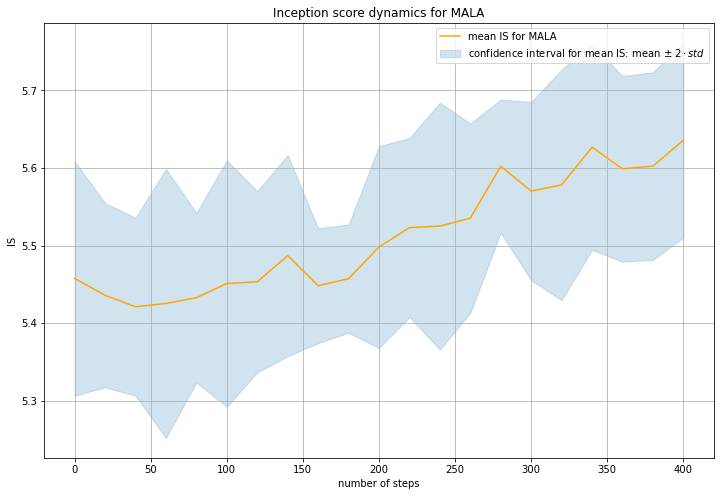

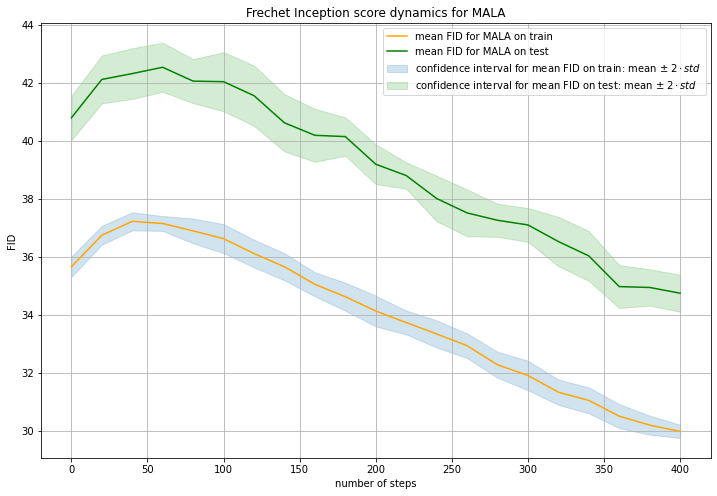

In [16]:
method_name = "MALA"
figsize = (12, 8)
plot_scores_cifar10_dynamics(inception_scores_mean,
                                 inception_scores_std,
                                 fid_scores_mean_train,
                                 fid_scores_mean_test,
                                 fid_scores_std_train,
                                 fid_scores_std_test,
                                 every_step, method_name,
                                 figsize,
                                 path_to_np_files,
                                 grad_step,
                                 eps_scale,
                                 coef = 2.0)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
method_name = 'mala'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 50

z_last_np, zs = mala_sampling(target_gan, proposal, batch_size, n,
                              path_to_save, file_name, every_step, 
                              n_steps, grad_step, eps_scale)



  2%|▏         | 1/50 [09:03<7:23:34, 543.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_0.npy was saved, file shape = (21, 1000, 100)


  4%|▍         | 2/50 [18:10<7:15:36, 544.52s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_1000.npy was saved, file shape = (21, 1000, 100)


  6%|▌         | 3/50 [27:18<7:07:10, 545.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_2000.npy was saved, file shape = (21, 1000, 100)


  8%|▊         | 4/50 [36:25<6:58:30, 545.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_3000.npy was saved, file shape = (21, 1000, 100)


 10%|█         | 5/50 [45:32<6:49:41, 546.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_4000.npy was saved, file shape = (21, 1000, 100)


 12%|█▏        | 6/50 [54:39<6:40:46, 546.52s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_5000.npy was saved, file shape = (21, 1000, 100)


 14%|█▍        | 7/50 [1:03:46<6:31:44, 546.62s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_6000.npy was saved, file shape = (21, 1000, 100)


 16%|█▌        | 8/50 [1:12:52<6:22:37, 546.62s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_7000.npy was saved, file shape = (21, 1000, 100)


 18%|█▊        | 9/50 [1:21:59<6:13:33, 546.68s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_8000.npy was saved, file shape = (21, 1000, 100)


 20%|██        | 10/50 [1:31:06<6:04:32, 546.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_9000.npy was saved, file shape = (21, 1000, 100)


 22%|██▏       | 11/50 [1:40:13<5:55:26, 546.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_10000.npy was saved, file shape = (21, 1000, 100)


 24%|██▍       | 12/50 [1:49:20<5:46:22, 546.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_11000.npy was saved, file shape = (21, 1000, 100)


 26%|██▌       | 13/50 [1:58:27<5:37:15, 546.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_12000.npy was saved, file shape = (21, 1000, 100)


 28%|██▊       | 14/50 [2:07:35<5:28:12, 547.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_13000.npy was saved, file shape = (21, 1000, 100)


 30%|███       | 15/50 [2:16:42<5:19:08, 547.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_14000.npy was saved, file shape = (21, 1000, 100)


 32%|███▏      | 16/50 [2:25:49<5:10:04, 547.20s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_15000.npy was saved, file shape = (21, 1000, 100)


 34%|███▍      | 17/50 [2:34:57<5:00:58, 547.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_16000.npy was saved, file shape = (21, 1000, 100)


 36%|███▌      | 18/50 [2:44:04<4:51:51, 547.23s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_17000.npy was saved, file shape = (21, 1000, 100)


 38%|███▊      | 19/50 [2:53:11<4:42:43, 547.23s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_18000.npy was saved, file shape = (21, 1000, 100)


 40%|████      | 20/50 [3:02:18<4:33:35, 547.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_19000.npy was saved, file shape = (21, 1000, 100)


 42%|████▏     | 21/50 [3:11:25<4:24:28, 547.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_20000.npy was saved, file shape = (21, 1000, 100)


 44%|████▍     | 22/50 [3:20:32<4:15:18, 547.09s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_21000.npy was saved, file shape = (21, 1000, 100)


 46%|████▌     | 23/50 [3:29:39<4:06:11, 547.09s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_22000.npy was saved, file shape = (21, 1000, 100)


 48%|████▊     | 24/50 [3:38:46<3:57:04, 547.10s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_23000.npy was saved, file shape = (21, 1000, 100)


 50%|█████     | 25/50 [3:47:54<3:48:02, 547.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_24000.npy was saved, file shape = (21, 1000, 100)


 52%|█████▏    | 26/50 [3:57:01<3:38:53, 547.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_25000.npy was saved, file shape = (21, 1000, 100)


 54%|█████▍    | 27/50 [4:06:09<3:29:46, 547.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_26000.npy was saved, file shape = (21, 1000, 100)


 56%|█████▌    | 28/50 [4:15:16<3:20:39, 547.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_27000.npy was saved, file shape = (21, 1000, 100)


 58%|█████▊    | 29/50 [4:24:23<3:11:32, 547.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_28000.npy was saved, file shape = (21, 1000, 100)


 60%|██████    | 30/50 [4:33:30<3:02:25, 547.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_29000.npy was saved, file shape = (21, 1000, 100)


 62%|██████▏   | 31/50 [4:42:38<2:53:17, 547.23s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_30000.npy was saved, file shape = (21, 1000, 100)


 64%|██████▍   | 32/50 [4:51:45<2:44:10, 547.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_31000.npy was saved, file shape = (21, 1000, 100)


 66%|██████▌   | 33/50 [5:00:52<2:35:03, 547.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_32000.npy was saved, file shape = (21, 1000, 100)


 68%|██████▊   | 34/50 [5:10:00<2:25:57, 547.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_33000.npy was saved, file shape = (21, 1000, 100)


 70%|███████   | 35/50 [5:19:07<2:16:49, 547.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_34000.npy was saved, file shape = (21, 1000, 100)


 72%|███████▏  | 36/50 [5:28:14<2:07:42, 547.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_35000.npy was saved, file shape = (21, 1000, 100)


 74%|███████▍  | 37/50 [5:37:21<1:58:34, 547.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_36000.npy was saved, file shape = (21, 1000, 100)


 76%|███████▌  | 38/50 [5:46:29<1:49:27, 547.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_37000.npy was saved, file shape = (21, 1000, 100)


 78%|███████▊  | 39/50 [5:55:36<1:40:21, 547.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_38000.npy was saved, file shape = (21, 1000, 100)


 80%|████████  | 40/50 [6:04:44<1:31:15, 547.54s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_39000.npy was saved, file shape = (21, 1000, 100)


 82%|████████▏ | 41/50 [6:13:52<1:22:07, 547.54s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_40000.npy was saved, file shape = (21, 1000, 100)


 84%|████████▍ | 42/50 [6:22:59<1:12:59, 547.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_41000.npy was saved, file shape = (21, 1000, 100)


 86%|████████▌ | 43/50 [6:32:06<1:03:51, 547.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_42000.npy was saved, file shape = (21, 1000, 100)


 88%|████████▊ | 44/50 [6:41:13<54:43, 547.28s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_43000.npy was saved, file shape = (21, 1000, 100)


 90%|█████████ | 45/50 [6:50:20<45:35, 547.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_44000.npy was saved, file shape = (21, 1000, 100)


 92%|█████████▏| 46/50 [6:59:27<36:28, 547.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_45000.npy was saved, file shape = (21, 1000, 100)


 94%|█████████▍| 47/50 [7:08:34<27:21, 547.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_46000.npy was saved, file shape = (21, 1000, 100)


 96%|█████████▌| 48/50 [7:17:41<18:14, 547.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_47000.npy was saved, file shape = (21, 1000, 100)


 98%|█████████▊| 49/50 [7:26:48<09:07, 547.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_48000.npy was saved, file shape = (21, 1000, 100)


100%|██████████| 50/50 [7:35:55<00:00, 547.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_49000.npy was saved, file shape = (21, 1000, 100)


In [33]:
batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
method_name = 'mala'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 50

load_np = []

for i in tqdm(range(0, n, batch_size)):
    cur_file_name = file_name + f"_batch_num_{i}.npy"
    cur_path_to_save = os.path.join(path_to_save, cur_file_name)
    cur_zs = np.load(cur_path_to_save)
    load_np.append(cur_zs)
    
load_np = np.array(load_np)
    

100%|██████████| 50/50 [00:00<00:00, 803.06it/s]


In [34]:
load_np.shape

(50, 21, 1000, 100)

In [15]:
load_np = np.concatenate(load_np.transpose(0, 2, 1, 3), axis = 0).transpose(1, 0, 2)

In [16]:
load_np.shape

(21, 50000, 100)

In [25]:
method_name = 'mala'
random_seed = 42
every_step = 50
path_to_save_cifar10_np = os.path.join(cwd, '..', 'samples', 'cifar10', 'numpy_files')
path_to_save_cifar10 = os.path.join(cwd, '..', 'samples', 'cifar10', 'downloaded_dataset')
mala_scores = calculate_cifar10_statistics(z_agg_step = load_np, 
                                           G = G,
                                           device = device, 
                                           batch_size = args.batch_size,
                                           path_to_save_cifar10 = path_to_save_cifar10,
                                           path_to_save_cifar10_np = path_to_save_cifar10_np,
                                           method_name = method_name,
                                           random_seed = random_seed,
                                           every_step = every_step)

------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.45884757258539, std inception score = 0.07988136341616872
time for inception calculation = 394.426s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:22,  8.84it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_0.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.76s/it, mean=39.6]

FID score for test CIFAR10 with mala: mean 39.62882295543382, score 0.4578858817004737
time for FID calculation on test = 84.892s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:52,  8.85it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.28s/it, mean=35.7]


FID score for train CIFAR10 with mala: mean 35.716967444687825, score 0.22371321329750932
time for FID calculation on train = 320.888s
------------------------------------
step = 50
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.417796007663021, std inception score = 0.0600268914537397
time for inception calculation = 394.725s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.10it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_50.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it, mean=41.1]

FID score for test CIFAR10 with mala: mean 41.08252646808229, score 0.5936941489273531
time for FID calculation on test = 82.297s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:57,  8.53it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_50.npy


FID: 100%|██████████| 10/10 [01:20<00:00,  8.04s/it, mean=37.2]


FID score for train CIFAR10 with mala: mean 37.1922994538953, score 0.2049920783668513
time for FID calculation on train = 319.257s
------------------------------------
step = 100
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.456239274131327, std inception score = 0.07315441018053934
time for inception calculation = 396.011s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.16it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_100.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.60s/it, mean=41.4]

FID score for test CIFAR10 with mala: mean 41.35401359919398, score 0.5709091761240765
time for FID calculation on test = 82.496s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.62it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_100.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.13s/it, mean=36.3]


FID score for train CIFAR10 with mala: mean 36.32682473173017, score 0.2481812108083394
time for FID calculation on train = 319.719s
------------------------------------
step = 150
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.483846839551438, std inception score = 0.06895895818394271
time for inception calculation = 393.816s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.17it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_150.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.74s/it, mean=39.2]

FID score for test CIFAR10 with mala: mean 39.18248334887498, score 0.5347235225223436
time for FID calculation on test = 83.722s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.70it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_150.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.20s/it, mean=35] 


FID score for train CIFAR10 with mala: mean 34.971849746886804, score 0.21054866227706057
time for FID calculation on train = 319.971s
------------------------------------
step = 200
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.543309420424913, std inception score = 0.09042810123493036
time for inception calculation = 393.749s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.18it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_200.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it, mean=38.7]

FID score for test CIFAR10 with mala: mean 38.71357816932721, score 0.5140713580687232
time for FID calculation on test = 82.264s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.73it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_200.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.16s/it, mean=34] 


FID score for train CIFAR10 with mala: mean 33.98570688283264, score 0.20125872814609005
time for FID calculation on train = 320.487s
------------------------------------
step = 250
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.554513652618619, std inception score = 0.05883967293327334
time for inception calculation = 395.411s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.06it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_250.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.62s/it, mean=37.5]

FID score for test CIFAR10 with mala: mean 37.48818831444139, score 0.6085502586750112
time for FID calculation on test = 82.875s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.74it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_250.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.18s/it, mean=32.8]


FID score for train CIFAR10 with mala: mean 32.820425577213214, score 0.18455317337840849
time for FID calculation on train = 319.542s
------------------------------------
step = 300
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.599243543213851, std inception score = 0.05349975549271408
time for inception calculation = 394.946s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.13it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_300.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.62s/it, mean=36.6]

FID score for test CIFAR10 with mala: mean 36.59403535072595, score 0.45367119270486983
time for FID calculation on test = 82.784s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:51,  8.96it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_300.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.13s/it, mean=31.6]


FID score for train CIFAR10 with mala: mean 31.644581404401926, score 0.20380117522311816
time for FID calculation on train = 320.682s
------------------------------------
step = 350
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.578758156089011, std inception score = 0.04805259432876943
time for inception calculation = 397.471s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.20it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_350.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it, mean=35.4]

FID score for test CIFAR10 with mala: mean 35.443908763504496, score 0.44125199972894086
time for FID calculation on test = 83.219s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.69it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_350.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.10s/it, mean=30.6]


FID score for train CIFAR10 with mala: mean 30.599815489161706, score 0.23716330634382993
time for FID calculation on train = 319.344s
------------------------------------
step = 400
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.623139921023645, std inception score = 0.059980080904299043
time for inception calculation = 393.32s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.12it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_400.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.54s/it, mean=34.6]

FID score for test CIFAR10 with mala: mean 34.64908025135941, score 0.38036943034409976
time for FID calculation on test = 82.18s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.67it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_400.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.22s/it, mean=29.9]


FID score for train CIFAR10 with mala: mean 29.88098476919074, score 0.21498150428802232
time for FID calculation on train = 320.309s
------------------------------------
step = 450
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.664939262000052, std inception score = 0.061992601947015925
time for inception calculation = 394.973s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.11it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_450.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.59s/it, mean=33.5]

FID score for test CIFAR10 with mala: mean 33.4960236665318, score 0.4329698479475451
time for FID calculation on test = 82.576s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.58it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_450.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.31s/it, mean=28.9]


FID score for train CIFAR10 with mala: mean 28.915707999818608, score 0.17235066735581572
time for FID calculation on train = 322.287s
------------------------------------
step = 500
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.643635990825888, std inception score = 0.06945305562640967
time for inception calculation = 396.017s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.20it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_500.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.75s/it, mean=33.6]

FID score for test CIFAR10 with mala: mean 33.63741908816265, score 0.3875524255586911
time for FID calculation on test = 83.915s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.56it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_500.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.21s/it, mean=28.3]


FID score for train CIFAR10 with mala: mean 28.286151055282357, score 0.13584866087074032
time for FID calculation on train = 321.746s
------------------------------------
step = 550
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.6983645792508755, std inception score = 0.059100051192131506
time for inception calculation = 396.825s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.18it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_550.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.60s/it, mean=32.7]

FID score for test CIFAR10 with mala: mean 32.743441162633204, score 0.4214609386597772
time for FID calculation on test = 82.444s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:52,  8.84it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_550.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.34s/it, mean=27.8]


FID score for train CIFAR10 with mala: mean 27.769015829488232, score 0.18631318707130942
time for FID calculation on train = 321.347s
------------------------------------
step = 600
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.727499310013199, std inception score = 0.06358598478288784
time for inception calculation = 393.035s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.13it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_600.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it, mean=31.7]

FID score for test CIFAR10 with mala: mean 31.69065869582124, score 0.3849855895075974
time for FID calculation on test = 83.458s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.67it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_600.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.44s/it, mean=27.2]


FID score for train CIFAR10 with mala: mean 27.150044607211175, score 0.1564837552348126
time for FID calculation on train = 322.139s
------------------------------------
step = 650
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.7532630183386075, std inception score = 0.057884257667898044
time for inception calculation = 397.407s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.14it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_650.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.67s/it, mean=31.3]

FID score for test CIFAR10 with mala: mean 31.32172872742489, score 0.4723490772658432
time for FID calculation on test = 82.936s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.69it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_650.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.13s/it, mean=26.6]


FID score for train CIFAR10 with mala: mean 26.615207051630733, score 0.18270073772272757
time for FID calculation on train = 319.131s
------------------------------------
step = 700
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.764751127295654, std inception score = 0.07557078768356633
time for inception calculation = 394.471s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.13it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_700.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it, mean=30.7]

FID score for test CIFAR10 with mala: mean 30.66126790715275, score 0.4751658850550372
time for FID calculation on test = 82.217s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:51,  8.94it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_700.npy


FID: 100%|██████████| 10/10 [01:20<00:00,  8.03s/it, mean=26] 


FID score for train CIFAR10 with mala: mean 26.00840524551856, score 0.20262902675109773
time for FID calculation on train = 318.683s
------------------------------------
step = 750
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.746254676718315, std inception score = 0.08360989912644819
time for inception calculation = 395.743s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.10it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_750.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, mean=30.2]

FID score for test CIFAR10 with mala: mean 30.23625955367704, score 0.43164456099110915
time for FID calculation on test = 81.41s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.69it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_750.npy


FID: 100%|██████████| 10/10 [01:20<00:00,  8.07s/it, mean=25.8]


FID score for train CIFAR10 with mala: mean 25.771794199406088, score 0.22200302761452864
time for FID calculation on train = 318.223s
------------------------------------
step = 800
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.78839582181833, std inception score = 0.07648153293984333
time for inception calculation = 396.322s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.08it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_800.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.60s/it, mean=30.3]

FID score for test CIFAR10 with mala: mean 30.339362105176217, score 0.3244205998433895
time for FID calculation on test = 82.889s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.59it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_800.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.18s/it, mean=25.3]


FID score for train CIFAR10 with mala: mean 25.25879514515568, score 0.17569771332333312
time for FID calculation on train = 320.65s
------------------------------------
step = 850
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.79434808232252, std inception score = 0.06941717438196444
time for inception calculation = 394.621s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.15it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_850.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it, mean=29.9]

FID score for test CIFAR10 with mala: mean 29.909971955899927, score 0.36222684192879534
time for FID calculation on test = 82.224s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.64it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_850.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.32s/it, mean=25.1]


FID score for train CIFAR10 with mala: mean 25.120110505518642, score 0.16143005966535606
time for FID calculation on train = 321.198s
------------------------------------
step = 900
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.812769604086621, std inception score = 0.05977483145319044
time for inception calculation = 393.745s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.19it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_900.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.63s/it, mean=29.9]

FID score for test CIFAR10 with mala: mean 29.850536580818055, score 0.37716059755201814
time for FID calculation on test = 82.695s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.76it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_900.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.27s/it, mean=24.8]


FID score for train CIFAR10 with mala: mean 24.762439124441606, score 0.1557749596984622
time for FID calculation on train = 321.416s
------------------------------------
step = 950
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.845712681933903, std inception score = 0.11053832926136747
time for inception calculation = 393.963s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.08it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_950.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.62s/it, mean=29.5]

FID score for test CIFAR10 with mala: mean 29.51458655107978, score 0.32177061863793655
time for FID calculation on test = 83.055s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.64it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_950.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.22s/it, mean=24.5]


FID score for train CIFAR10 with mala: mean 24.526618884516836, score 0.1644144021049147
time for FID calculation on train = 319.882s
------------------------------------
step = 1000
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala mean inception score = 5.851780460286611, std inception score = 0.055301205173452155
time for inception calculation = 397.429s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.16it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_test_step_1000.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.67s/it, mean=29.4]

FID score for test CIFAR10 with mala: mean 29.37332597188571, score 0.41835361601602505
time for FID calculation on test = 83.287s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:51,  8.94it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_pretrained_fake_train_step_1000.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.26s/it, mean=24.3]

FID score for train CIFAR10 with mala: mean 24.265336461808925, score 0.16982129977728314
time for FID calculation on train = 320.238s


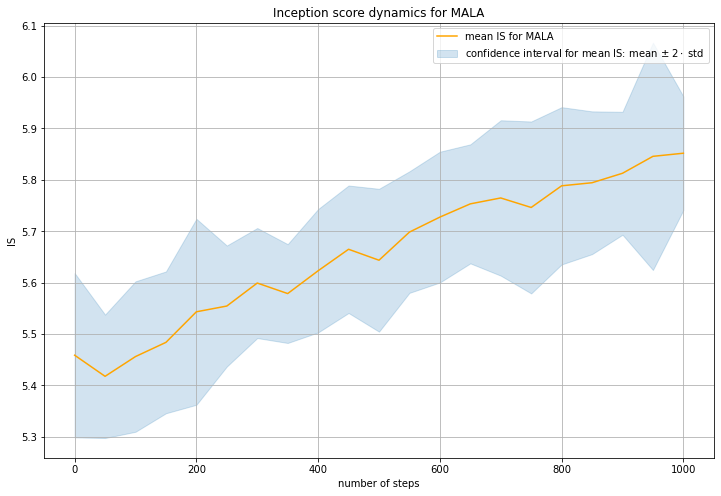

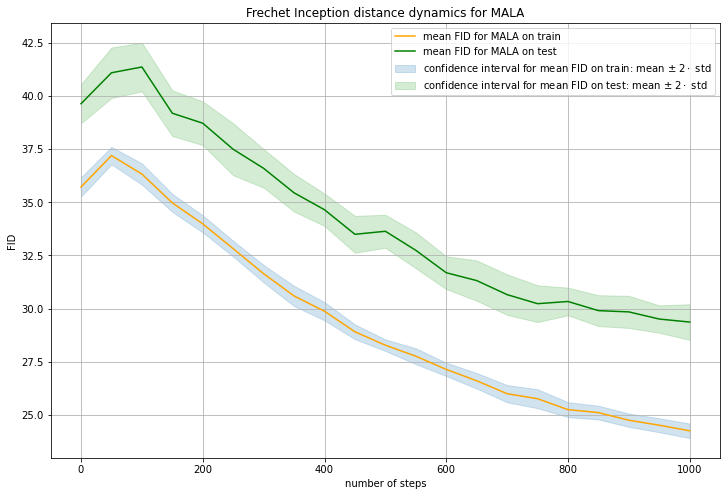

In [27]:
method_name = "MALA"
figsize = (12, 8)
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
plot_scores_cifar10_dynamics(mala_scores,
                                every_step, method_name,
                                 figsize,
                                 path_to_np_files,
                                 grad_step,
                                 eps_scale,
                                 coef = 2.0)

In [43]:
batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
method_name = 'mala'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 50

load_np = []

for i in tqdm(range(0, n, batch_size)):
    cur_file_name = file_name + f"_batch_num_{i}.npy"
    cur_path_to_save = os.path.join(path_to_save, cur_file_name)
    cur_zs = np.load(cur_path_to_save)
    load_np.append(cur_zs)
    
load_np = np.array(load_np)
load_torch = torch.FloatTensor(load_np)

100%|██████████| 50/50 [00:00<00:00, 776.00it/s]


In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
method_name = 'mala_continue_after_1000'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 50
continue_z = load_torch.to(device)

z_last_np, zs = mala_sampling(target_gan, proposal, batch_size, n,
                              path_to_save, file_name, every_step,
                              continue_z,
                              n_steps, grad_step, eps_scale)

  2%|▏         | 1/50 [09:02<7:23:16, 542.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_0.npy was saved, file shape = (21, 1000, 100)


  4%|▍         | 2/50 [18:13<7:16:04, 545.09s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_1000.npy was saved, file shape = (21, 1000, 100)


  6%|▌         | 3/50 [27:23<7:08:12, 546.66s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_2000.npy was saved, file shape = (21, 1000, 100)


  8%|▊         | 4/50 [36:34<6:59:59, 547.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_3000.npy was saved, file shape = (21, 1000, 100)


 10%|█         | 5/50 [45:44<6:51:29, 548.65s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_4000.npy was saved, file shape = (21, 1000, 100)


 12%|█▏        | 6/50 [54:55<6:42:49, 549.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_5000.npy was saved, file shape = (21, 1000, 100)


 14%|█▍        | 7/50 [1:04:06<6:33:58, 549.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_6000.npy was saved, file shape = (21, 1000, 100)


 16%|█▌        | 8/50 [1:13:17<6:25:04, 550.10s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_7000.npy was saved, file shape = (21, 1000, 100)


 18%|█▊        | 9/50 [1:22:28<6:16:06, 550.41s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_8000.npy was saved, file shape = (21, 1000, 100)


 20%|██        | 10/50 [1:31:39<6:07:08, 550.70s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_9000.npy was saved, file shape = (21, 1000, 100)


 22%|██▏       | 11/50 [1:40:51<5:58:08, 550.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_10000.npy was saved, file shape = (21, 1000, 100)


 24%|██▍       | 12/50 [1:50:02<5:49:00, 551.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_11000.npy was saved, file shape = (21, 1000, 100)


 26%|██▌       | 13/50 [1:59:13<5:39:51, 551.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_12000.npy was saved, file shape = (21, 1000, 100)


 28%|██▊       | 14/50 [2:08:25<5:30:43, 551.21s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_13000.npy was saved, file shape = (21, 1000, 100)


 30%|███       | 15/50 [2:17:36<5:21:34, 551.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_14000.npy was saved, file shape = (21, 1000, 100)


 32%|███▏      | 16/50 [2:26:47<5:12:22, 551.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_15000.npy was saved, file shape = (21, 1000, 100)


 34%|███▍      | 17/50 [2:35:59<5:03:13, 551.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_16000.npy was saved, file shape = (21, 1000, 100)


 36%|███▌      | 18/50 [2:45:10<4:54:02, 551.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_17000.npy was saved, file shape = (21, 1000, 100)


 38%|███▊      | 19/50 [2:54:21<4:44:48, 551.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_18000.npy was saved, file shape = (21, 1000, 100)


 40%|████      | 20/50 [3:03:32<4:35:36, 551.22s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_19000.npy was saved, file shape = (21, 1000, 100)


 42%|████▏     | 21/50 [3:12:43<4:26:23, 551.17s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_20000.npy was saved, file shape = (21, 1000, 100)


 44%|████▍     | 22/50 [3:21:55<4:17:11, 551.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_21000.npy was saved, file shape = (21, 1000, 100)


 46%|████▌     | 23/50 [3:31:06<4:07:59, 551.10s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_22000.npy was saved, file shape = (21, 1000, 100)


 48%|████▊     | 24/50 [3:40:17<3:58:49, 551.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_23000.npy was saved, file shape = (21, 1000, 100)


 50%|█████     | 25/50 [3:49:28<3:49:37, 551.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_24000.npy was saved, file shape = (21, 1000, 100)


 52%|█████▏    | 26/50 [3:58:39<3:40:27, 551.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_25000.npy was saved, file shape = (21, 1000, 100)


 54%|█████▍    | 27/50 [4:07:50<3:31:15, 551.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_26000.npy was saved, file shape = (21, 1000, 100)


 56%|█████▌    | 28/50 [4:17:01<3:22:05, 551.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_27000.npy was saved, file shape = (21, 1000, 100)


 58%|█████▊    | 29/50 [4:26:12<3:12:53, 551.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_28000.npy was saved, file shape = (21, 1000, 100)


 60%|██████    | 30/50 [4:35:24<3:03:43, 551.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_29000.npy was saved, file shape = (21, 1000, 100)


 62%|██████▏   | 31/50 [4:44:35<2:54:32, 551.20s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_30000.npy was saved, file shape = (21, 1000, 100)


 64%|██████▍   | 32/50 [4:53:46<2:45:21, 551.22s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_31000.npy was saved, file shape = (21, 1000, 100)


 66%|██████▌   | 33/50 [5:02:57<2:36:10, 551.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_32000.npy was saved, file shape = (21, 1000, 100)


 68%|██████▊   | 34/50 [5:12:09<2:26:59, 551.20s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_33000.npy was saved, file shape = (21, 1000, 100)


 70%|███████   | 35/50 [5:21:20<2:17:48, 551.21s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_34000.npy was saved, file shape = (21, 1000, 100)


 72%|███████▏  | 36/50 [5:30:31<2:08:36, 551.17s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_35000.npy was saved, file shape = (21, 1000, 100)


 74%|███████▍  | 37/50 [5:39:42<1:59:25, 551.17s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_36000.npy was saved, file shape = (21, 1000, 100)


 76%|███████▌  | 38/50 [5:48:53<1:50:14, 551.23s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_37000.npy was saved, file shape = (21, 1000, 100)


 78%|███████▊  | 39/50 [5:58:05<1:41:04, 551.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_38000.npy was saved, file shape = (21, 1000, 100)


 80%|████████  | 40/50 [6:07:16<1:31:52, 551.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_39000.npy was saved, file shape = (21, 1000, 100)


 82%|████████▏ | 41/50 [6:16:27<1:22:41, 551.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_40000.npy was saved, file shape = (21, 1000, 100)


 84%|████████▍ | 42/50 [6:25:39<1:13:30, 551.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_41000.npy was saved, file shape = (21, 1000, 100)


 86%|████████▌ | 43/50 [6:34:50<1:04:18, 551.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_42000.npy was saved, file shape = (21, 1000, 100)


 88%|████████▊ | 44/50 [6:44:01<55:07, 551.26s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_43000.npy was saved, file shape = (21, 1000, 100)


 90%|█████████ | 45/50 [6:53:13<45:56, 551.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_44000.npy was saved, file shape = (21, 1000, 100)


 92%|█████████▏| 46/50 [7:02:24<36:45, 551.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_45000.npy was saved, file shape = (21, 1000, 100)


 94%|█████████▍| 47/50 [7:11:35<27:33, 551.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_46000.npy was saved, file shape = (21, 1000, 100)


 96%|█████████▌| 48/50 [7:20:46<18:22, 551.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_47000.npy was saved, file shape = (21, 1000, 100)


 98%|█████████▊| 49/50 [7:29:57<09:11, 551.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_48000.npy was saved, file shape = (21, 1000, 100)


100%|██████████| 50/50 [7:39:08<00:00, 550.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_continue_after_1000_eps_0.01_noise_scale_0.1_nsteps_1000_batch_num_49000.npy was saved, file shape = (21, 1000, 100)


In [16]:
batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
method_name = 'mala_continue_after_1000'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'

load_mala_batches = load_data_from_batches(n, batch_size, path_to_save, file_name)

100%|██████████| 50/50 [00:00<00:00, 261.57it/s]


In [8]:
method_name = 'mala_continue'
random_seed = 42
every_step = 50
path_to_save_cifar10_np = os.path.join(cwd, '..', 'samples', 'cifar10', 'numpy_files')
path_to_save_cifar10 = os.path.join(cwd, '..', 'samples', 'cifar10', 'downloaded_dataset')
mala_scores = calculate_cifar10_statistics(z_agg_step = load_mala_batches, 
                                           G = G,
                                           device = device, 
                                           batch_size = args.batch_size,
                                           path_to_save_cifar10 = path_to_save_cifar10,
                                           path_to_save_cifar10_np = path_to_save_cifar10_np,
                                           method_name = method_name,
                                           random_seed = random_seed,
                                           every_step = every_step)

------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 5.851780460286611, std inception score = 0.055301205173452155
time for inception calculation = 481.262s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:35,  5.56it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_0.npy


FID: 100%|██████████| 10/10 [01:31<00:00,  9.11s/it, mean=29.4]

FID score for test CIFAR10 with mala_continue: mean 29.37332597188571, score 0.41835361601602505
time for FID calculation on test = 169.021s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<02:47,  5.98it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [03:16<00:00, 19.69s/it, mean=24.3]


FID score for train CIFAR10 with mala_continue: mean 24.265336461808925, score 0.16982129977728314
time for FID calculation on train = 540.623s
------------------------------------
step = 50
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 5.863500306221166, std inception score = 0.08362685813736725
time for inception calculation = 513.686s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:38,  5.12it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_50.npy


FID: 100%|██████████| 10/10 [01:39<00:00,  9.97s/it, mean=28.8]

FID score for test CIFAR10 with mala_continue: mean 28.7753314304908, score 0.40425806626990296
time for FID calculation on test = 163.92s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<02:22,  7.02it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_50.npy


FID: 100%|██████████| 10/10 [03:05<00:00, 18.54s/it, mean=23.7]


FID score for train CIFAR10 with mala_continue: mean 23.654465965024524, score 0.13752092769469157
time for FID calculation on train = 520.92s
------------------------------------
step = 100
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 5.899262739008832, std inception score = 0.06087193996902448
time for inception calculation = 503.061s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:39,  5.08it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_100.npy


FID: 100%|██████████| 10/10 [01:40<00:00, 10.03s/it, mean=28.5]

FID score for test CIFAR10 with mala_continue: mean 28.50768032249453, score 0.33994250544967963
time for FID calculation on test = 166.829s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.71it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_100.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.82s/it, mean=23.3]


FID score for train CIFAR10 with mala_continue: mean 23.310058914701766, score 0.14352240432516034
time for FID calculation on train = 357.515s
------------------------------------
step = 150
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 5.893607136616922, std inception score = 0.07726064170757012
time for inception calculation = 391.374s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.16it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_150.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.57s/it, mean=28.2]

FID score for test CIFAR10 with mala_continue: mean 28.184138707152584, score 0.2916411105530124
time for FID calculation on test = 82.244s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.66it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_150.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.83s/it, mean=23.2]


FID score for train CIFAR10 with mala_continue: mean 23.1630589854464, score 0.12375619944181881
time for FID calculation on train = 316.637s
------------------------------------
step = 200
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 5.957945761433026, std inception score = 0.06245821570045187
time for inception calculation = 391.602s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.15it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_200.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it, mean=28.5]

FID score for test CIFAR10 with mala_continue: mean 28.546840909614026, score 0.4043953080027326
time for FID calculation on test = 81.238s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:53,  8.77it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_200.npy


FID: 100%|██████████| 10/10 [01:17<00:00,  7.80s/it, mean=23.1]


FID score for train CIFAR10 with mala_continue: mean 23.116557182375526, score 0.11521096895912165
time for FID calculation on train = 315.56s
------------------------------------
step = 250
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 5.955124966567276, std inception score = 0.06854139904835603
time for inception calculation = 393.046s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.21it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_250.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it, mean=27.9]

FID score for test CIFAR10 with mala_continue: mean 27.89462080554486, score 0.4024299152815669
time for FID calculation on test = 80.58s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.68it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_250.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.96s/it, mean=23]


FID score for train CIFAR10 with mala_continue: mean 23.006055759034627, score 0.10018137186330975
time for FID calculation on train = 317.702s
------------------------------------
step = 300
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 5.938673937661369, std inception score = 0.05682789935298069
time for inception calculation = 396.28s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.15it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_300.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it, mean=28.1]

FID score for test CIFAR10 with mala_continue: mean 28.051642759539654, score 0.3649290854707395
time for FID calculation on test = 82.335s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.56it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_300.npy


FID: 100%|██████████| 10/10 [01:17<00:00,  7.78s/it, mean=23.1]


FID score for train CIFAR10 with mala_continue: mean 23.064342746412013, score 0.11571959288155596
time for FID calculation on train = 316.21s
------------------------------------
step = 350
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 5.971638324504648, std inception score = 0.0675870796003561
time for inception calculation = 394.978s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.21it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_350.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it, mean=28.3]

FID score for test CIFAR10 with mala_continue: mean 28.296849372465907, score 0.3730609261069916
time for FID calculation on test = 80.984s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.69it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_350.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.90s/it, mean=23.1]


FID score for train CIFAR10 with mala_continue: mean 23.133907996872942, score 0.10598312031322528
time for FID calculation on train = 317.004s
------------------------------------
step = 400
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 5.984272644275819, std inception score = 0.04712166441987547
time for inception calculation = 396.307s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.21it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_400.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it, mean=28.2]

FID score for test CIFAR10 with mala_continue: mean 28.202678710469435, score 0.3669093381980219
time for FID calculation on test = 81.416s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:53,  8.82it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_400.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.88s/it, mean=23] 


FID score for train CIFAR10 with mala_continue: mean 23.004718153026232, score 0.11468538490708553
time for FID calculation on train = 317.294s
------------------------------------
step = 450
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.035086076334905, std inception score = 0.07258160903397337
time for inception calculation = 396.998s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.08it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_450.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it, mean=28.1]

FID score for test CIFAR10 with mala_continue: mean 28.051757192112962, score 0.3819394917742723
time for FID calculation on test = 80.083s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.76it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_450.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.98s/it, mean=23] 


FID score for train CIFAR10 with mala_continue: mean 23.002052756228647, score 0.10189372410800797
time for FID calculation on train = 318.436s
------------------------------------
step = 500
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.074184445865732, std inception score = 0.05618417080090556
time for inception calculation = 393.347s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.16it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_500.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it, mean=28.1]

FID score for test CIFAR10 with mala_continue: mean 28.121283246032892, score 0.4312129339380785
time for FID calculation on test = 81.237s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.66it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_500.npy


FID: 100%|██████████| 10/10 [01:17<00:00,  7.77s/it, mean=23] 


FID score for train CIFAR10 with mala_continue: mean 23.049543420947334, score 0.11448174830549877
time for FID calculation on train = 315.64s
------------------------------------
step = 550
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.045767843733316, std inception score = 0.0807381296798556
time for inception calculation = 392.847s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.18it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_550.npy


FID: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it, mean=28.6]

FID score for test CIFAR10 with mala_continue: mean 28.589930223784012, score 0.3634360273388888
time for FID calculation on test = 79.994s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.61it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_550.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.93s/it, mean=23.3]


FID score for train CIFAR10 with mala_continue: mean 23.292333254275047, score 0.09426604985869885
time for FID calculation on train = 317.377s
------------------------------------
step = 600
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.049117115845645, std inception score = 0.0755243788647461
time for inception calculation = 394.043s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.17it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_600.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.49s/it, mean=28.4]

FID score for test CIFAR10 with mala_continue: mean 28.40180663555468, score 0.3321575110664123
time for FID calculation on test = 80.898s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.67it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_600.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.91s/it, mean=23.4]


FID score for train CIFAR10 with mala_continue: mean 23.430693881299373, score 0.10829579709758985
time for FID calculation on train = 316.501s
------------------------------------
step = 650
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.072010394881904, std inception score = 0.09073185604959835
time for inception calculation = 393.785s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.19it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_650.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it, mean=28.5]

FID score for test CIFAR10 with mala_continue: mean 28.530099930669383, score 0.3893534293601583
time for FID calculation on test = 80.508s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.70it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_650.npy


FID: 100%|██████████| 10/10 [01:17<00:00,  7.76s/it, mean=23.6]


FID score for train CIFAR10 with mala_continue: mean 23.560137947370038, score 0.0942486868073548
time for FID calculation on train = 315.163s
------------------------------------
step = 700
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.050663866010906, std inception score = 0.0462626555104228
time for inception calculation = 392.787s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.12it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_700.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it, mean=28.9]

FID score for test CIFAR10 with mala_continue: mean 28.91884891695573, score 0.3139690485549206
time for FID calculation on test = 81.028s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:53,  8.78it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_700.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.87s/it, mean=23.8]


FID score for train CIFAR10 with mala_continue: mean 23.82148010946367, score 0.08702686525033933
time for FID calculation on train = 317.207s
------------------------------------
step = 750
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.066039502854354, std inception score = 0.08062651440161232
time for inception calculation = 394.98s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.13it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_750.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.51s/it, mean=29] 

FID score for test CIFAR10 with mala_continue: mean 28.984156179999577, score 0.4026440509479483
time for FID calculation on test = 81.404s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.62it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_750.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.92s/it, mean=24] 


FID score for train CIFAR10 with mala_continue: mean 24.036271332445402, score 0.07598668051657856
time for FID calculation on train = 317.022s
------------------------------------
step = 800
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.049891199715995, std inception score = 0.05026396033297452
time for inception calculation = 396.186s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.19it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_800.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it, mean=29.2]

FID score for test CIFAR10 with mala_continue: mean 29.24029017989188, score 0.4056510985030663
time for FID calculation on test = 81.373s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.62it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_800.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.91s/it, mean=24.2]


FID score for train CIFAR10 with mala_continue: mean 24.203687512698032, score 0.11822705472613168
time for FID calculation on train = 316.654s
------------------------------------
step = 850
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.072169804690766, std inception score = 0.06939004199287008
time for inception calculation = 391.671s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.16it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_850.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it, mean=29.3]

FID score for test CIFAR10 with mala_continue: mean 29.34988821721533, score 0.4063000665982547
time for FID calculation on test = 80.882s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.70it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_850.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.83s/it, mean=24.4]


FID score for train CIFAR10 with mala_continue: mean 24.356731408937424, score 0.10836019243769712
time for FID calculation on train = 315.612s
------------------------------------
step = 900
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.067154047903139, std inception score = 0.06893837403006438
time for inception calculation = 392.985s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.14it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_900.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.51s/it, mean=29.4]

FID score for test CIFAR10 with mala_continue: mean 29.368085512868692, score 0.3424152464373537
time for FID calculation on test = 81.562s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.61it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_900.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.89s/it, mean=24.4]


FID score for train CIFAR10 with mala_continue: mean 24.429318184932782, score 0.12866781674112793
time for FID calculation on train = 317.402s
------------------------------------
step = 950
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.07916077691931, std inception score = 0.09977253766405982
time for inception calculation = 394.3s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.21it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_950.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.56s/it, mean=30] 

FID score for test CIFAR10 with mala_continue: mean 29.96950777844875, score 0.3544630192017349
time for FID calculation on test = 82.033s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.64it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_950.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.94s/it, mean=24.7]


FID score for train CIFAR10 with mala_continue: mean 24.742939533193358, score 0.13955673084521827
time for FID calculation on train = 317.027s
------------------------------------
step = 1000
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue mean inception score = 6.0722576437100075, std inception score = 0.08247653118296798
time for inception calculation = 391.653s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.19it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_test_step_1000.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.50s/it, mean=30.1]

FID score for test CIFAR10 with mala_continue: mean 30.074235170331576, score 0.44577875992846155
time for FID calculation on test = 81.013s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.73it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_pretrained_fake_train_step_1000.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.81s/it, mean=24.9]

FID score for train CIFAR10 with mala_continue: mean 24.92287689714542, score 0.09344891092920352
time for FID calculation on train = 315.066s


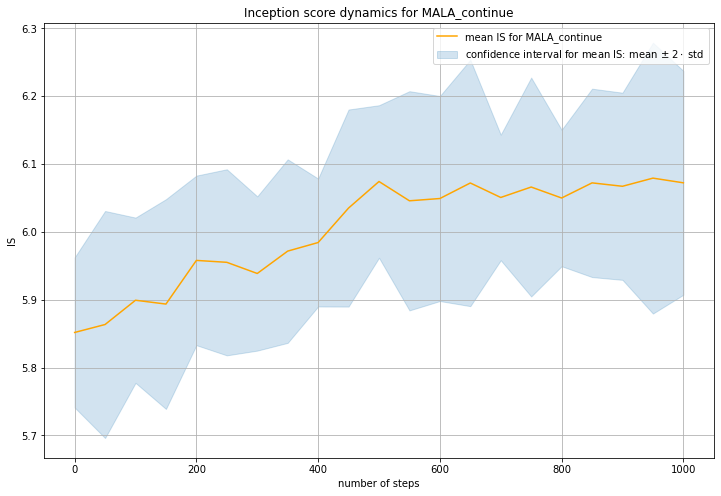

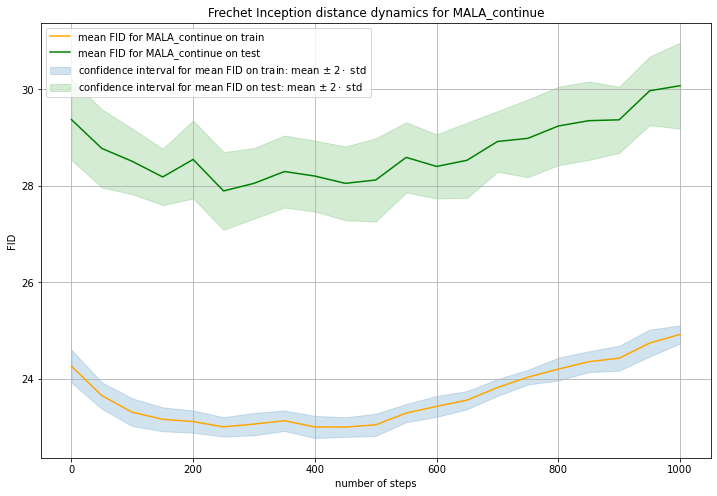

In [9]:
method_name = "MALA_continue"
figsize = (12, 8)
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
plot_scores_cifar10_dynamics(mala_scores,
                                every_step, method_name,
                                 figsize,
                                 path_to_np_files,
                                 grad_step,
                                 eps_scale,
                                 coef = 2.0)

In [17]:
method_name = 'mala_continue_recalculate'
random_seed = 42
every_step = 50
path_to_save_cifar10_np = os.path.join(cwd, '..', 'samples', 'cifar10', 'numpy_files')
path_to_save_cifar10 = os.path.join(cwd, '..', 'samples', 'cifar10', 'downloaded_dataset')
mala_scores = calculate_cifar10_statistics(z_agg_step = load_mala_batches, 
                                           G = G,
                                           device = device, 
                                           batch_size = args.batch_size,
                                           path_to_save_cifar10 = path_to_save_cifar10,
                                           path_to_save_cifar10_np = path_to_save_cifar10_np,
                                           method_name = method_name,
                                           random_seed = random_seed,
                                           every_step = every_step)

------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 5.851780460286611, std inception score = 0.055301205173452155
time for inception calculation = 391.71s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.21it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_0.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.65s/it, mean=29.4]

FID score for test CIFAR10 with mala_continue_recalculate: mean 29.37332597188571, score 0.41835361601602505
time for FID calculation on test = 82.444s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.66it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.81s/it, mean=24.3]


FID score for train CIFAR10 with mala_continue_recalculate: mean 24.265336461808925, score 0.16982129977728314
time for FID calculation on train = 315.639s
------------------------------------
step = 50
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 5.863500306221166, std inception score = 0.08362685813736725
time for inception calculation = 393.848s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.15it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_50.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it, mean=28.8]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.7753314304908, score 0.40425806626990296
time for FID calculation on test = 80.665s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.71it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_50.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.86s/it, mean=23.7]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.654465965024524, score 0.13752092769469157
time for FID calculation on train = 317.27s
------------------------------------
step = 100
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 5.899262739008832, std inception score = 0.06087193996902448
time for inception calculation = 396.578s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.12it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_100.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it, mean=28.5]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.50768032249453, score 0.33994250544967963
time for FID calculation on test = 81.843s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.68it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_100.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.92s/it, mean=23.3]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.310058914701766, score 0.14352240432516034
time for FID calculation on train = 317.711s
------------------------------------
step = 150
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 5.893607136616922, std inception score = 0.07726064170757012
time for inception calculation = 397.521s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:22,  8.86it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_150.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.70s/it, mean=28.2]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.184138707152584, score 0.2916411105530124
time for FID calculation on test = 84.187s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.56it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_150.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.48s/it, mean=23.2]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.1630589854464, score 0.12375619944181881
time for FID calculation on train = 326.222s
------------------------------------
step = 200
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 5.957945761433026, std inception score = 0.06245821570045187
time for inception calculation = 396.437s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.16it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_200.npy


FID: 100%|██████████| 10/10 [00:38<00:00,  3.80s/it, mean=28.5]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.546840909614026, score 0.4043953080027326
time for FID calculation on test = 84.534s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.69it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_200.npy


FID: 100%|██████████| 10/10 [01:29<00:00,  8.92s/it, mean=23.1]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.116557182375526, score 0.11521096895912165
time for FID calculation on train = 329.16s
------------------------------------
step = 250
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 5.955124966567276, std inception score = 0.06854139904835603
time for inception calculation = 550.738s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:34,  5.77it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_250.npy


FID: 100%|██████████| 10/10 [01:55<00:00, 11.56s/it, mean=27.9]

FID score for test CIFAR10 with mala_continue_recalculate: mean 27.89462080554486, score 0.4024299152815669
time for FID calculation on test = 189.971s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<02:35,  6.44it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_250.npy


FID: 100%|██████████| 10/10 [01:35<00:00,  9.52s/it, mean=23]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.006055759034627, score 0.10018137186330975
time for FID calculation on train = 448.576s
------------------------------------
step = 300
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 5.938673937661369, std inception score = 0.05682789935298069
time for inception calculation = 401.252s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.17it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_300.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.50s/it, mean=28.1]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.051642759539654, score 0.3649290854707395
time for FID calculation on test = 81.724s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.58it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_300.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.88s/it, mean=23.1]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.064342746412013, score 0.11571959288155596
time for FID calculation on train = 317.672s
------------------------------------
step = 350
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 5.971638324504648, std inception score = 0.0675870796003561
time for inception calculation = 396.632s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.16it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_350.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.45s/it, mean=28.3]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.296849372465907, score 0.3730609261069916
time for FID calculation on test = 80.62s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.71it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_350.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.89s/it, mean=23.1]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.133907996872942, score 0.10598312031322528
time for FID calculation on train = 317.468s
------------------------------------
step = 400
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 5.984272644275819, std inception score = 0.04712166441987547
time for inception calculation = 394.668s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.08it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_400.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.52s/it, mean=28.2]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.202678710469435, score 0.3669093381980219
time for FID calculation on test = 81.568s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.71it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_400.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.92s/it, mean=23] 


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.004718153026232, score 0.11468538490708553
time for FID calculation on train = 317.965s
------------------------------------
step = 450
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.035086076334905, std inception score = 0.07258160903397337
time for inception calculation = 394.846s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.08it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_450.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it, mean=28.1]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.051757192112962, score 0.3819394917742723
time for FID calculation on test = 82.14s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.70it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_450.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.96s/it, mean=23] 


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.002052756228647, score 0.10189372410800797
time for FID calculation on train = 317.182s
------------------------------------
step = 500
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.074184445865732, std inception score = 0.05618417080090556
time for inception calculation = 397.222s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.22it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_500.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.52s/it, mean=28.1]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.121283246032892, score 0.4312129339380785
time for FID calculation on test = 81.351s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.71it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_500.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.86s/it, mean=23] 


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.049543420947334, score 0.11448174830549877
time for FID calculation on train = 316.833s
------------------------------------
step = 550
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.045767843733316, std inception score = 0.0807381296798556
time for inception calculation = 396.027s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.14it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_550.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, mean=28.6]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.589930223784012, score 0.3634360273388888
time for FID calculation on test = 80.997s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:52,  8.84it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_550.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.89s/it, mean=23.3]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.292333254275047, score 0.09426604985869885
time for FID calculation on train = 317.675s
------------------------------------
step = 600
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.049117115845645, std inception score = 0.0755243788647461
time for inception calculation = 393.101s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.17it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_600.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it, mean=28.4]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.40180663555468, score 0.3321575110664123
time for FID calculation on test = 82.185s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.73it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_600.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.87s/it, mean=23.4]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.430693881299373, score 0.10829579709758985
time for FID calculation on train = 316.111s
------------------------------------
step = 650
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.072010394881904, std inception score = 0.09073185604959835
time for inception calculation = 393.934s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.22it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_650.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.51s/it, mean=28.5]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.530099930669383, score 0.3893534293601583
time for FID calculation on test = 81.353s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:52,  8.91it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_650.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.87s/it, mean=23.6]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.560137947370038, score 0.0942486868073548
time for FID calculation on train = 315.754s
------------------------------------
step = 700
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.050663866010906, std inception score = 0.0462626555104228
time for inception calculation = 396.249s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.18it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_700.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.54s/it, mean=28.9]

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.91884891695573, score 0.3139690485549206
time for FID calculation on test = 81.46s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:50,  9.01it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_700.npy


FID: 100%|██████████| 10/10 [01:20<00:00,  8.02s/it, mean=23.8]


FID score for train CIFAR10 with mala_continue_recalculate: mean 23.82148010946367, score 0.08702686525033933
time for FID calculation on train = 317.573s
------------------------------------
step = 750
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.066039502854354, std inception score = 0.08062651440161232
time for inception calculation = 397.464s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.19it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_750.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it, mean=29] 

FID score for test CIFAR10 with mala_continue_recalculate: mean 28.984156179999577, score 0.4026440509479483
time for FID calculation on test = 81.283s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.64it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_750.npy


FID: 100%|██████████| 10/10 [01:20<00:00,  8.00s/it, mean=24] 


FID score for train CIFAR10 with mala_continue_recalculate: mean 24.036271332445402, score 0.07598668051657856
time for FID calculation on train = 317.503s
------------------------------------
step = 800
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.049891199715995, std inception score = 0.05026396033297452
time for inception calculation = 395.529s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.20it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_800.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.52s/it, mean=29.2]

FID score for test CIFAR10 with mala_continue_recalculate: mean 29.24029017989188, score 0.4056510985030663
time for FID calculation on test = 81.48s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.65it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_800.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.99s/it, mean=24.2]


FID score for train CIFAR10 with mala_continue_recalculate: mean 24.203687512698032, score 0.11822705472613168
time for FID calculation on train = 317.353s
------------------------------------
step = 850
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.072169804690766, std inception score = 0.06939004199287008
time for inception calculation = 393.05s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.14it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_850.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it, mean=29.3]

FID score for test CIFAR10 with mala_continue_recalculate: mean 29.34988821721533, score 0.4063000665982547
time for FID calculation on test = 81.89s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:54,  8.70it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_850.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.86s/it, mean=24.4]


FID score for train CIFAR10 with mala_continue_recalculate: mean 24.356731408937424, score 0.10836019243769712
time for FID calculation on train = 315.685s
------------------------------------
step = 900
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.067154047903139, std inception score = 0.06893837403006438
time for inception calculation = 396.805s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.26it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_900.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.57s/it, mean=29.4]

FID score for test CIFAR10 with mala_continue_recalculate: mean 29.368085512868692, score 0.3424152464373537
time for FID calculation on test = 81.801s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:53,  8.81it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_900.npy


FID: 100%|██████████| 10/10 [01:18<00:00,  7.89s/it, mean=24.4]


FID score for train CIFAR10 with mala_continue_recalculate: mean 24.429318184932782, score 0.12866781674112793
time for FID calculation on train = 316.234s
------------------------------------
step = 950
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.07916077691931, std inception score = 0.09977253766405982
time for inception calculation = 395.318s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.21it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_950.npy


FID: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it, mean=30] 

FID score for test CIFAR10 with mala_continue_recalculate: mean 29.96950777844875, score 0.3544630192017349
time for FID calculation on test = 81.065s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:56,  8.59it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_950.npy


FID: 100%|██████████| 10/10 [01:19<00:00,  7.93s/it, mean=24.7]


FID score for train CIFAR10 with mala_continue_recalculate: mean 24.742939533193358, score 0.13955673084521827
time for FID calculation on train = 316.993s
------------------------------------
step = 1000
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
mala_continue_recalculate mean inception score = 6.0722576437100075, std inception score = 0.08247653118296798
time for inception calculation = 394.133s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  0%|          | 1/200 [00:00<00:21,  9.23it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_test_step_1000.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.54s/it, mean=30.1]

FID score for test CIFAR10 with mala_continue_recalculate: mean 30.074235170331576, score 0.44577875992846155
time for FID calculation on test = 81.477s
start to calculate FID score for train CIFAR10...


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 1/1000 [00:00<01:55,  8.67it/s]

/home/daniil/gans-mcmc/gans_sampling/notebooks/../samples/cifar10/numpy_files/mala_continue_recalculate_pretrained_fake_train_step_1000.npy


FID: 100%|██████████| 10/10 [01:20<00:00,  8.00s/it, mean=24.9]

FID score for train CIFAR10 with mala_continue_recalculate: mean 24.92287689714542, score 0.09344891092920352
time for FID calculation on train = 317.454s


## CiterSIR

In [ ]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n, n_steps, grad_step, eps_scale)